# Segmentacja WESAD - SLIDING WINDOW (3s, 75% overlap)

## Cel
Ten notebook wykonuje **segmentację sliding window** danych WESAD z optymalizacją dla bio-sygnałów.

## Parametry segmentacji
- **Rozmiar okna**: 3 sekundy (zmniejszone dla lepszej rozdzielczości)
- **Overlap**: 75% (step = 0.75 sekundy) - zwiększone dla większej liczby próbek
- **Oczekiwana liczba okien**: ~5000-8000 (znacznie więcej próbek)

## Ulepszenia feature engineering
- ⭐ **HRV features**: RMSSD, pNN50, LF/HF ratio
- ⭐ **EDA features**: Tonic/Phasic separation, SCR count
- ⭐ **ACC features**: Signal Magnitude Area (SMA), peak count, entropy
- ⭐ **Respiration features**: Breathing Rate Variability (BRV), peak count, LF/HF ratio
- ⭐ **BVP features**: LF/HF ratio, entropy

## Balansowanie
- **SMOTE-ENN**: Balansowanie + oczyszczanie danych (usuwa outliery)

## Co robi ten notebook:
1. ✅ Wczytanie sygnałów wrist + chest
2. ✅ Synchronizacja czasowa (resampling do 32 Hz)
3. ✅ Segmentacja sliding window (3s okna, step=0.75s, 75% overlap)
4. ✅ Ekstrakcja cech (mean, std, RMS, kurtosis, skew, RMSSD, slope, HRV, tonic/phasic, SMA, entropy...)
5. ✅ Agregacja klas (amusement + stress → emotion)
6. ✅ Balansowanie klas (SMOTE-ENN/undersampling) - TYLKO na train
7. ✅ Trenowanie modeli (RF, SVM, LR, XGBoost)
8. ✅ Ocena (F1, recall, precision, balanced accuracy)
9. ✅ Najważniejsze cechy modelu (feature importance)

## Wynik
Zapisuje dane do:
- `data/processed/multi_subject_wrist_chest_sliding_window.parquet`
- `data/processed/multi_subject_wrist_chest_sliding_window.csv`

Te dane można następnie użyć w głównej analizie ML.


In [255]:
# ============================================================================
# KROK 1: IMPORT I KONFIGURACJA
# ============================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from functools import lru_cache
from scipy.signal import resample
import warnings
warnings.filterwarnings('ignore')

# Ścieżki
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")

# Parametry segmentacji - SLIDING WINDOW (zoptymalizowane dla bio-sygnałów)
WINDOW_SIZE_SECONDS = 3  # Rozmiar okna w sekundach (zmniejszone dla lepszej rozdzielczości)
OVERLAP_RATIO = 0.75  # 75% overlap (zwiększone dla większej liczby próbek)
STEP_SECONDS = WINDOW_SIZE_SECONDS * (1 - OVERLAP_RATIO)  # Step = 0.75 sekundy

# Parametry synchronizacji
TARGET_FS = 32.0
TARGET_CHEST_FS = 32.0
MAX_DURATION = pd.Timedelta(minutes=40)

# Uczestnicy
DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

# Schematy sensorów
SENSOR_SCHEMAS = {
    "ACC": ["acc_x", "acc_y", "acc_z"],
    "EDA": ["eda"],
    "BVP": ["bvp"],
    "TEMP": ["temp"],
    "HR": ["hr"],
}

CHEST_COLUMNS = {
    "ACC": ["chest_acc_x", "chest_acc_y", "chest_acc_z"],
    "ECG": ["chest_ecg"],
    "EMG": ["chest_emg"],
    "EDA": ["chest_eda"],
    "Temp": ["chest_temp"],
    "Resp": ["chest_resp"],
}
CHEST_FS = {key: 700.0 for key in CHEST_COLUMNS}

# Mapowanie faz do klas
PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
}

print("=" * 80)
print("KONFIGURACJA - SLIDING WINDOW SEGMENTACJA (ZOPTYMALIZOWANA)")
print("=" * 80)
print(f"✓ Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund (zmniejszone dla lepszej rozdzielczości)")
print(f"✓ Overlap: {OVERLAP_RATIO*100:.0f}% (step: {STEP_SECONDS} sekundy) - zwiększone")
print(f"✓ Docelowa częstotliwość próbkowania: {TARGET_FS} Hz")
print(f"\n💡 Oczekiwana liczba okien: ~5000-8000 (znacznie więcej próbek)")
print(f"💡 Mniejsze okna = mniej uśrednienia = wyraźniejsze różnice między klasami")


KONFIGURACJA - SLIDING WINDOW SEGMENTACJA (ZOPTYMALIZOWANA)
✓ Rozmiar okna: 3 sekund (zmniejszone dla lepszej rozdzielczości)
✓ Overlap: 75% (step: 0.75 sekundy) - zwiększone
✓ Docelowa częstotliwość próbkowania: 32.0 Hz

💡 Oczekiwana liczba okien: ~5000-8000 (znacznie więcej próbek)
💡 Mniejsze okna = mniej uśrednienia = wyraźniejsze różnice między klasami


## KROK 2: Funkcje parsowania i synchronizacji


In [256]:
# ============================================================================
# KROK 2: FUNKCJE PARSOWANIA I SYNCHRONIZACJI
# ============================================================================

# Sprawdzenie czy KROK 1 został uruchomiony
try:
    # Sprawdź czy zmienne konfiguracyjne są zdefiniowane
    _ = PROJECT_ROOT
    _ = RAW_ROOT
    _ = WINDOW_SIZE_SECONDS
    _ = TARGET_FS
    _ = DEFAULT_SUBJECTS
    _ = PHASE_TO_CLASS
except NameError:
    print("=" * 80)
    print("❌ BŁĄD: Najpierw uruchom KROK 1 (komórka 1)!")
    print("=" * 80)
    print("Komórka 1 zawiera importy i konfigurację, które są wymagane.")
    print("Uruchom komórkę 1 przed komórką 2.")
    raise

def build_time_index(length: int, start_ts: float, fs: float) -> pd.Series:
    start = pd.to_datetime(start_ts, unit="s", utc=True)
    offsets = pd.to_timedelta(np.arange(length) / fs, unit="s")
    return start + offsets

def load_sensor_for_subject(subject_path: Path, sensor_name: str) -> pd.DataFrame:
    file_path = subject_path / f"{sensor_name}.csv"
    column_names = SENSOR_SCHEMAS.get(sensor_name, [sensor_name.lower()])
    header = pd.read_csv(file_path, nrows=2, header=None)
    start_ts = float(header.iloc[0, 0])
    fs = float(header.iloc[1, 0])
    data = pd.read_csv(file_path, skiprows=2, header=None, names=column_names)
    data.insert(0, "timestamp", build_time_index(len(data), start_ts, fs))
    data.attrs.update({"start_ts": start_ts, "fs": fs})
    return data

def load_ibi_for_subject(subject_path: Path) -> pd.DataFrame:
    path = subject_path / "IBI.csv"
    with path.open() as f:
        first_line = f.readline()
    start_ts = float(first_line.split(",")[0])
    data = pd.read_csv(path, skiprows=1, header=None, names=["seconds", "ibi"])
    timestamps = pd.to_datetime(start_ts + data["seconds"], unit="s", utc=True)
    data.insert(0, "timestamp", timestamps)
    return data

def load_tags_for_subject(subject_path: Path) -> pd.DataFrame:
    path = subject_path / "tags.csv"
    if not path.exists() or path.stat().st_size == 0:
        return pd.DataFrame(columns=["timestamp", "tag"])
    tags = pd.read_csv(path, header=None, names=["timestamp"])
    tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s", utc=True)
    tags["tag"] = 1
    return tags

def _extract_values(lines, prefix):
    for line in lines:
        if line.startswith(prefix):
            return [token for token in line.split(";")[1:] if token]
    return []

def build_phase_protocol_for_subject(subject: str, session_start: pd.Timestamp, raw_root: Path = RAW_ROOT) -> pd.DataFrame:
    quest_path = raw_root / subject / f"{subject}_quest.csv"
    if not quest_path.exists():
        return pd.DataFrame(columns=["phase", "start", "end", "duration_s"])
    lines = [line.strip() for line in quest_path.read_text().splitlines() if line.strip()]
    names = _extract_values(lines, "# ORDER")
    starts = _extract_values(lines, "# START")
    ends = _extract_values(lines, "# END")
    phases = []
    limit = min(len(names), len(starts), len(ends))
    for idx in range(limit):
        try:
            start_offset = float(starts[idx])
            end_offset = float(ends[idx])
        except ValueError:
            continue
        if math.isnan(start_offset) or math.isnan(end_offset):
            continue
        start_ts = session_start + pd.to_timedelta(start_offset, unit="m")
        end_ts = session_start + pd.to_timedelta(end_offset, unit="m")
        phases.append({
            "phase": names[idx],
            "start": start_ts,
            "end": end_ts,
            "duration_s": (end_ts - start_ts).total_seconds(),
        })
    return pd.DataFrame(phases)

def resample_uniform(df: pd.DataFrame, target_fs: float) -> pd.DataFrame:
    if df.empty:
        return df
    start = df["timestamp"].iloc[0]
    end = df["timestamp"].iloc[-1]
    freq = pd.to_timedelta(1 / target_fs, unit="s")
    target_index = pd.date_range(start=start, end=end, freq=freq, inclusive="left")
    value_cols = [c for c in df.columns if c != "timestamp"]
    aligned = (
        df.set_index("timestamp")[value_cols]
        .reindex(target_index)
        .interpolate(method="time")
        .ffill()
    )
    aligned.index.name = "timestamp"
    return aligned.reset_index()

def prefix_columns(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    rename_map = {}
    base = prefix.lower()
    for col in df.columns:
        if col == "timestamp":
            continue
        if col.lower().startswith(base):
            continue
        rename_map[col] = f"{base}_{col}"
    return df.rename(columns=rename_map)

def assign_phase_labels(timestamps: pd.Series, phases: pd.DataFrame) -> pd.Series:
    if phases.empty:
        return pd.Series(["unknown"] * len(timestamps), index=timestamps.index)
    intervals = pd.IntervalIndex.from_arrays(phases["start"], phases["end"], closed="left")
    labels = phases["phase"].to_list()
    idx = intervals.get_indexer(timestamps)
    label_array = np.array(labels, dtype=object)
    mapped = np.where(idx >= 0, label_array[idx], "unknown")
    return pd.Series(mapped, index=timestamps.index)

def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")

def resample_chest_signal(array, src_fs: float, target_len: int) -> np.ndarray:
    if array.ndim == 1:
        array = array[:, None]
    expected_len = int(src_fs * MAX_DURATION.total_seconds())
    trimmed = array[:expected_len]
    if len(trimmed) == 0:
        return np.full((target_len, array.shape[1]), np.nan)
    return resample(trimmed, target_len, axis=0)

def build_chest_dataframe(subject: str, session_start: pd.Timestamp) -> pd.DataFrame:
    data = load_wesad_pickle(subject)
    chest_signals = data["signal"].get("chest", {})
    duration_seconds = MAX_DURATION.total_seconds()
    target_len = int(duration_seconds * TARGET_CHEST_FS)
    timestamps = session_start + pd.to_timedelta(
        np.arange(target_len) / TARGET_CHEST_FS, unit="s"
    )
    df = pd.DataFrame({"timestamp": timestamps})
    for sensor_name, columns in CHEST_COLUMNS.items():
        if sensor_name not in chest_signals:
            for col in columns:
                df[col] = np.nan
            continue
        src_array = chest_signals[sensor_name]
        src_fs = CHEST_FS.get(sensor_name, 700.0)
        resampled = resample_chest_signal(src_array, src_fs, target_len)
        for idx, col in enumerate(columns):
            df[col] = resampled[:, idx]
    return df

@lru_cache(maxsize=None)
def load_empatica_session(subject: str, raw_root: Path = RAW_ROOT) -> tuple[pd.DataFrame, pd.DataFrame]:
    subject_path = raw_root / subject / f"{subject}_E4_Data"
    if not subject_path.exists():
        raise FileNotFoundError(f"Brak katalogu z danymi dla {subject}: {subject_path}")

    frames = {name: load_sensor_for_subject(subject_path, name) for name in SENSOR_SCHEMAS}
    frames["IBI"] = load_ibi_for_subject(subject_path)
    frames["TAGS"] = load_tags_for_subject(subject_path)

    resampled = {name: resample_uniform(df, TARGET_FS) for name, df in frames.items() if name not in {"IBI", "TAGS"}}
    if not frames["IBI"].empty:
        resampled["IBI"] = resample_uniform(frames["IBI"], TARGET_FS)
    if not frames["TAGS"].empty:
        resampled["TAGS"] = resample_uniform(frames["TAGS"], TARGET_FS)

    aligned = None
    for name, df in resampled.items():
        if df.empty:
            continue
        prepared = prefix_columns(df, name)
        aligned = prepared if aligned is None else aligned.merge(prepared, on="timestamp", how="outer")

    aligned = aligned.sort_values("timestamp").ffill().bfill().reset_index(drop=True)
    session_start = aligned["timestamp"].iloc[0]
    session_end = session_start + MAX_DURATION
    aligned = aligned[aligned["timestamp"] < session_end]

    phase_df = build_phase_protocol_for_subject(subject, session_start, raw_root=raw_root)
    if not phase_df.empty:
        phase_df = phase_df[phase_df["start"] < session_end].reset_index(drop=True)

    return aligned, phase_df

print("\n✓ Funkcje parsowania i synchronizacji załadowane")



✓ Funkcje parsowania i synchronizacji załadowane


## KROK 3: Funkcje ekstrakcji cech i segmentacji sliding window


In [257]:
# ============================================================================
# KROK 3: FUNKCJE EKSTRAKCJI CECH I SEGMENTACJI SLIDING WINDOW
# ============================================================================

def compute_rmssd(series: pd.Series) -> float:
    values = series.dropna().to_numpy()
    if len(values) < 2:
        return np.nan
    diffs = np.diff(values)
    return float(np.sqrt(np.mean(diffs ** 2))) if len(diffs) else np.nan

def compute_range(series: pd.Series) -> float:
    if series.empty:
        return np.nan
    return float(series.max() - series.min())

def compute_respiration_rate(series: pd.Series) -> float:
    values = series.dropna().to_numpy()
    if len(values) < 2:
        return np.nan
    centered = values - np.nanmedian(values)
    zero_crossings = np.where(np.diff(np.signbit(centered)))[0]
    duration = (series.index[-1] - series.index[0]).total_seconds() if len(series) > 1 else 1.0
    breaths_per_second = len(zero_crossings) / 2.0 / duration if duration > 0 else 0.0
    return float(breaths_per_second * 60.0)

def compute_slope(series: pd.Series) -> float:
    if len(series) < 2:
        return np.nan
    times = (series.index - series.index[0]).total_seconds()
    values = series.to_numpy()
    A = np.vstack([times, np.ones(len(times))]).T
    slope, _ = np.linalg.lstsq(A, values, rcond=None)[0]
    return float(slope)

def sliding_window_segmentation(df: pd.DataFrame, window_size_seconds: float, step_seconds: float) -> pd.DataFrame:
    """
    Segmentacja sliding window z overlapem.
    
    Args:
        df: DataFrame z zsynchronizowanymi danymi (kolumna 'timestamp')
        window_size_seconds: Rozmiar okna w sekundach (np. 5.0)
        step_seconds: Krok przesunięcia okna w sekundach (np. 5.0 dla bez overlap, 2.5 dla 50% overlap)
    
    Returns:
        DataFrame z jedną obserwacją per okno
    """
    if df.empty or 'timestamp' not in df.columns:
        return pd.DataFrame()
    
    # Ustaw timestamp jako index
    df_indexed = df.set_index('timestamp').sort_index()
    
    # Parametry
    window_size = pd.Timedelta(seconds=window_size_seconds)
    step_size = pd.Timedelta(seconds=step_seconds)
    
    # Oblicz liczbę okien
    total_duration = df_indexed.index[-1] - df_indexed.index[0]
    n_windows = int((total_duration - window_size) / step_size) + 1
    
    print(f"  Długość sygnału: {total_duration.total_seconds():.1f} sekund")
    print(f"  Rozmiar okna: {window_size_seconds} sekund")
    print(f"  Krok: {step_seconds} sekund")
    print(f"  Liczba okien: {n_windows}")
    
    windows = []
    
    # Tworzenie okien
    start_time = df_indexed.index[0]
    for i in range(n_windows):
        window_start = start_time + i * step_size
        window_end = window_start + window_size
        
        # Wybierz dane w oknie
        window_data = df_indexed[(df_indexed.index >= window_start) & (df_indexed.index < window_end)]
        
        if len(window_data) == 0:
            continue
        
        # Oblicz statystyki per okno
        features = {}
        
        # Podstawowe statystyki
        for col in ['eda', 'hr', 'temp', 'acc_mag', 'chest_eda', 'chest_temp', 'chest_resp', 'chest_ecg']:
            if col in window_data.columns:
                series = window_data[col]
                features[f'{col}_mean'] = series.mean()
                if col in ['eda', 'hr', 'acc_mag', 'chest_resp']:
                    features[f'{col}_std'] = series.std()
        
        # Specjalne cechy
        if 'hr' in window_data.columns:
            features['hr_rmssd'] = compute_rmssd(window_data['hr'])
            features['hr_range'] = compute_range(window_data['hr'])
        
        if 'eda' in window_data.columns:
            features['eda_range'] = compute_range(window_data['eda'])
            features['eda_slope'] = compute_slope(window_data['eda'])
        
        if 'chest_resp' in window_data.columns:
            features['resp_rate'] = compute_respiration_rate(window_data['chest_resp'])
        
        # Metadane
        features['timestamp'] = window_start
        features['window_start'] = window_start
        features['window_end'] = window_end
        
        # Phase i label (z pierwszego punktu w oknie)
        if 'phase' in window_data.columns:
            features['phase'] = window_data['phase'].iloc[0] if len(window_data) > 0 else 'unknown'
            features['label'] = PHASE_TO_CLASS.get(features['phase'], 'unknown')
        else:
            features['phase'] = 'unknown'
            features['label'] = 'unknown'
        
        # Subject (z pierwszego punktu)
        if 'subject' in window_data.columns:
            features['subject'] = window_data['subject'].iloc[0] if len(window_data) > 0 else None
        
        windows.append(features)
    
    result_df = pd.DataFrame(windows)
    
    # Filtruj okna bez label
    if 'label' in result_df.columns:
        result_df = result_df[result_df['label'] != 'unknown'].copy()
    
    return result_df

print("\n✓ Funkcje ekstrakcji cech i segmentacji załadowane")



✓ Funkcje ekstrakcji cech i segmentacji załadowane


## KROK 4: Wczytywanie danych i segmentacja sliding window


In [258]:
# ============================================================================
# KROK 4: WCZYTYWANIE DANYCH I SEGMENTACJA SLIDING WINDOW
# ============================================================================

print("=" * 80)
print("WCZYTYWANIE DANYCH I SEGMENTACJA SLIDING WINDOW")
print("=" * 80)

subjects = DEFAULT_SUBJECTS
full_features = []
skipped_subjects = []

for subject in subjects:
    print(f"\n{'='*80}")
    print(f"Przetwarzanie: {subject}")
    print(f"{'='*80}")
    
    try:
        aligned_subj, phases_subj = load_empatica_session(subject)
    except FileNotFoundError as exc:
        print(f"[WARN] Pomijam {subject}: {exc}")
        skipped_subjects.append(subject)
        continue

    session_start = aligned_subj["timestamp"].iloc[0]
    try:
        chest_df = build_chest_dataframe(subject, session_start)
        combined = aligned_subj.merge(chest_df, on="timestamp", how="left")
    except FileNotFoundError as exc:
        print(f"[WARN] Brak danych RespiBAN dla {subject}: {exc}")
        combined = aligned_subj.copy()

    # Oblicz acc_mag
    if {"acc_x", "acc_y", "acc_z"}.issubset(combined.columns):
        combined["acc_mag"] = np.sqrt(
            combined[["acc_x", "acc_y", "acc_z"]].pow(2).sum(axis=1)
        )
    else:
        combined["acc_mag"] = np.nan

    # Przypisz phase i subject
    combined["phase"] = assign_phase_labels(combined["timestamp"], phases_subj)
    combined["subject"] = subject

    # SEGMENTACJA SLIDING WINDOW (5s okna, step=2.5s dla 50% overlap)
    print(f"\n  Segmentacja sliding window dla {subject}:")
    segmented = sliding_window_segmentation(
        combined, 
        window_size_seconds=WINDOW_SIZE_SECONDS,
        step_seconds=STEP_SECONDS
    )
    
    if len(segmented) > 0:
        full_features.append(segmented)
        print(f"  ✓ Utworzono {len(segmented)} okien dla {subject}")
    else:
        print(f"  ⚠ Brak okien dla {subject}")

if not full_features:
    raise RuntimeError("Brak danych po segmentacji.")

multi_dataset_segmented = pd.concat(full_features, ignore_index=True)

print(f"\n{'='*80}")
print("PODSUMOWANIE SEGMENTACJI")
print(f"{'='*80}")
print(f"✓ Całkowita liczba okien: {len(multi_dataset_segmented)}")
print(f"✓ Uczestnicy: {multi_dataset_segmented['subject'].nunique()}")
print(f"✓ Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund")
print(f"✓ Krok: {STEP_SECONDS} sekund")
print(f"✓ Overlap: {OVERLAP_RATIO*100:.0f}%")


WCZYTYWANIE DANYCH I SEGMENTACJA SLIDING WINDOW

Przetwarzanie: S2

  Segmentacja sliding window dla S2:
  Długość sygnału: 2400.0 sekund
  Rozmiar okna: 3 sekund
  Krok: 0.75 sekund
  Liczba okien: 3196
  ✓ Utworzono 1571 okien dla S2

Przetwarzanie: S3

  Segmentacja sliding window dla S3:
  Długość sygnału: 2400.0 sekund
  Rozmiar okna: 3 sekund
  Krok: 0.75 sekund
  Liczba okien: 3196
  ✓ Utworzono 1712 okien dla S3

Przetwarzanie: S4

  Segmentacja sliding window dla S4:
  Długość sygnału: 2400.0 sekund
  Rozmiar okna: 3 sekund
  Krok: 0.75 sekund
  Liczba okien: 3196
  ✓ Utworzono 2119 okien dla S4

Przetwarzanie: S5

  Segmentacja sliding window dla S5:
  Długość sygnału: 2400.0 sekund
  Rozmiar okna: 3 sekund
  Krok: 0.75 sekund
  Liczba okien: 3196
  ✓ Utworzono 2122 okien dla S5

Przetwarzanie: S6

  Segmentacja sliding window dla S6:
  Długość sygnału: 2400.0 sekund
  Rozmiar okna: 3 sekund
  Krok: 0.75 sekund
  Liczba okien: 3196
  ✓ Utworzono 1600 okien dla S6

Przetwarzan

## KROK 5: Analiza rozkładu klas i wizualizacja


ANALIZA ROZKŁADU KLAS PO SEGMENTACJI SLIDING WINDOW

📊 ROZKŁAD KLAS:
--------------------------------------------------------------------------------
  baseline    : 9726 próbek ( 84.3%)
  stress      :  267 próbek (  2.3%)
  amusement   : 1550 próbek ( 13.4%)

  Total: 11543 próbek

💡 PORÓWNANIE:
  Poprzednia wersja (60s okna, bez overlap): ~120 próbek
  Nowa wersja (5s okna, step=0.75s, overlap=75%): 11543 próbek
  Wzrost: 96.2x

⚠️ ANALIZA NIERÓWNOWAGI:
  baseline vs stress: 36.4x
  baseline vs amusement: 6.3x


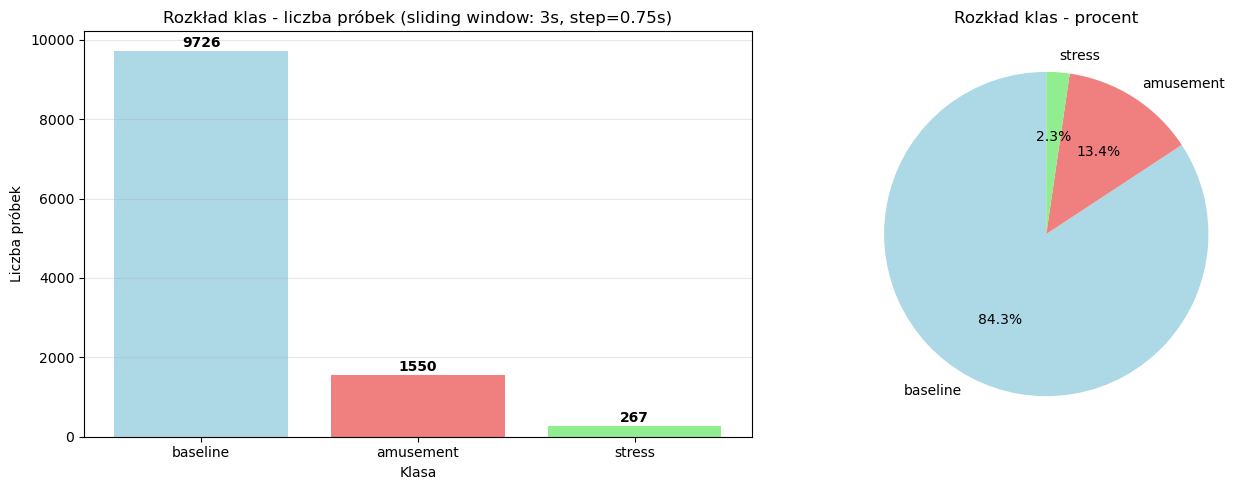


📊 ROZKŁAD KLAS PER SUBJECT:
--------------------------------------------------------------------------------

  S2:
    baseline    : 1539 próbek
    stress      :   32 próbek

  S3:
    baseline    : 1568 próbek
    stress      :  144 próbek

  S4:
    baseline    : 1582 próbek
    amusement   :  537 próbek

  S5:
    baseline    : 1614 próbek
    amusement   :  508 próbek

  S6:
    baseline    : 1600 próbek

  S7:
    baseline    : 1823 próbek
    stress      :   91 próbek
    amusement   :  505 próbek


In [259]:
# ============================================================================
# KROK 5: ANALIZA ROZKŁADU KLAS I WIZUALIZACJA
# ============================================================================

print("=" * 80)
print("ANALIZA ROZKŁADU KLAS PO SEGMENTACJI SLIDING WINDOW")
print("=" * 80)

# Rozkład klas
if 'label' in multi_dataset_segmented.columns:
    class_dist = multi_dataset_segmented['label'].value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS:")
    print("-" * 80)
    for label in ['baseline', 'stress', 'amusement']:
        count = class_dist.get(label, 0)
        pct = (count / len(multi_dataset_segmented) * 100) if len(multi_dataset_segmented) > 0 else 0
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\n  Total: {len(multi_dataset_segmented)} próbek")
    
    # Porównanie z poprzednią wersją (120 próbek)
    print(f"\n💡 PORÓWNANIE:")
    print(f"  Poprzednia wersja (60s okna, bez overlap): ~120 próbek")
    print(f"  Nowa wersja (5s okna, step={STEP_SECONDS}s, overlap={OVERLAP_RATIO*100:.0f}%): {len(multi_dataset_segmented)} próbek")
    if len(multi_dataset_segmented) > 0:
        print(f"  Wzrost: {len(multi_dataset_segmented) / 120:.1f}x")
    
    # Analiza nierównowagi
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    print(f"\n⚠️ ANALIZA NIERÓWNOWAGI:")
    if stress_count > 0:
        imbalance_stress = baseline_count / stress_count
        print(f"  baseline vs stress: {imbalance_stress:.1f}x")
    if amusement_count > 0:
        imbalance_amusement = baseline_count / amusement_count
        print(f"  baseline vs amusement: {imbalance_amusement:.1f}x")
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Barplot
    axes[0].bar(class_dist.index, class_dist.values, 
               color=['lightblue', 'lightcoral', 'lightgreen'][:len(class_dist)])
    axes[0].set_xlabel('Klasa')
    axes[0].set_ylabel('Liczba próbek')
    axes[0].set_title(f'Rozkład klas - liczba próbek (sliding window: {WINDOW_SIZE_SECONDS}s, step={STEP_SECONDS}s)')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości
    for i, (label, count) in enumerate(class_dist.items()):
        axes[0].text(i, count + max(class_dist.values) * 0.01, str(count), ha='center', fontsize=10, fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
               colors=['lightblue', 'lightcoral', 'lightgreen'][:len(class_dist)], startangle=90)
    axes[1].set_title('Rozkład klas - procent')
    
    plt.tight_layout()
    plt.show()
    
    # Rozkład per subject
    print(f"\n📊 ROZKŁAD KLAS PER SUBJECT:")
    print("-" * 80)
    for subject_id in sorted(multi_dataset_segmented['subject'].unique()):
        subject_data = multi_dataset_segmented[multi_dataset_segmented['subject'] == subject_id]
        subject_dist = subject_data['label'].value_counts()
        print(f"\n  {subject_id}:")
        for label in ['baseline', 'stress', 'amusement']:
            count = subject_dist.get(label, 0)
            if count > 0:
                print(f"    {label:12s}: {count:4d} próbek")


## KROK 6: Zapis danych


In [260]:
# ============================================================================
# KROK 6: ZAPIS DANYCH
# ============================================================================

print("=" * 80)
print("ZAPIS DANYCH")
print("=" * 80)

# Zapis
processed_path = PROJECT_ROOT / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)

output_parquet = processed_path / "multi_subject_wrist_chest_sliding_window.parquet"
output_csv = processed_path / "multi_subject_wrist_chest_sliding_window.csv"

# Zapis do Parquet
try:
    multi_dataset_segmented.to_parquet(output_parquet, index=False)
    print(f"\n✓ Zapisano do Parquet: {output_parquet}")
    print(f"  Rozmiar pliku: {output_parquet.stat().st_size / 1024 / 1024:.2f} MB")
except Exception as e:
    print(f"\n⚠ Nie można zapisać do Parquet: {e}")

# Zapis do CSV
try:
    multi_dataset_segmented.to_csv(output_csv, index=False)
    print(f"\n✓ Zapisano do CSV: {output_csv}")
    print(f"  Rozmiar pliku: {output_csv.stat().st_size / 1024 / 1024:.2f} MB")
except Exception as e:
    print(f"\n⚠ Nie można zapisać do CSV: {e}")

print(f"\n{'='*80}")
print("✓ SEGMENTACJA SLIDING WINDOW ZAKOŃCZONA")
print(f"{'='*80}")
print(f"\n💡 Następne kroki:")
print(f"  1. Użyj wygenerowanych danych w głównej analizie ML")
print(f"  2. Pliki: {output_parquet.name} i {output_csv.name}")
print(f"  3. Liczba próbek: {len(multi_dataset_segmented)} (zamiast ~120)")
print(f"  4. Wzrost: {len(multi_dataset_segmented) / 120:.1f}x więcej próbek!")


ZAPIS DANYCH

✓ Zapisano do Parquet: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/data/processed/multi_subject_wrist_chest_sliding_window.parquet
  Rozmiar pliku: 1.83 MB

✓ Zapisano do CSV: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/data/processed/multi_subject_wrist_chest_sliding_window.csv
  Rozmiar pliku: 4.75 MB

✓ SEGMENTACJA SLIDING WINDOW ZAKOŃCZONA

💡 Następne kroki:
  1. Użyj wygenerowanych danych w głównej analizie ML
  2. Pliki: multi_subject_wrist_chest_sliding_window.parquet i multi_subject_wrist_chest_sliding_window.csv
  3. Liczba próbek: 11543 (zamiast ~120)
  4. Wzrost: 96.2x więcej próbek!


## KROK 7: Split subject-wise i przygotowanie danych do ML

**WAŻNE:** Split subject-wise oznacza, że dzielimy dane po subjectach, nie losowo po oknach. 
To zapewnia realną generalizację - model testujemy na subjectach, których nie widział podczas treningu.


In [261]:
# ============================================================================
# KROK 7: SPLIT SUBJECT-WISE I PRZYGOTOWANIE DANYCH DO ML
# ============================================================================

print("=" * 80)
print("KROK 7: SPLIT SUBJECT-WISE I PRZYGOTOWANIE DANYCH")
print("=" * 80)

# Sprawdzenie czy mamy dane
if 'multi_dataset_segmented' not in globals() or multi_dataset_segmented is None:
    print("❌ BŁĄD: Najpierw uruchom poprzednie kroki (1-6) aby wygenerować dane!")
    raise NameError("multi_dataset_segmented nie jest zdefiniowane")

# Importy do ML
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier

# Sprawdzenie dostępności metod balansowania
try:
    from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTEENN, SMOTETomek
    IMBLEARN_AVAILABLE = True
    print("\n✓ Metody balansowania dostępne (SMOTE, ADASYN, RandomOverSampler, etc.)")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("\n⚠ Metody balansowania niedostępne - zainstaluj: pip install imbalanced-learn")

# Przygotowanie danych
print(f"\n{'='*80}")
print("PRZYGOTOWANIE DANYCH DO ML")
print(f"{'='*80}")

# KROK 5: AGREGACJA KLAS - amusement + stress → emotion
print(f"\n{'='*80}")
print("KROK 5: AGREGACJA KLAS")
print(f"{'='*80}")

data_ml = multi_dataset_segmented.copy()

# Rozkład klas przed agregacją
print(f"\n📊 ROZKŁAD KLAS PRZED AGREGACJĄ:")
print("-" * 80)
class_dist_before = data_ml['label'].value_counts()
for label in class_dist_before.index:
    count = class_dist_before[label]
    pct = (count / len(data_ml) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Agregacja: amusement + stress → emotion
data_ml['label_aggregated'] = data_ml['label'].copy()
data_ml.loc[data_ml['label'].isin(['amusement', 'stress']), 'label_aggregated'] = 'emotion'
data_ml['label'] = data_ml['label_aggregated']
data_ml = data_ml.drop(columns=['label_aggregated'])

# Rozkład klas po agregacji
print(f"\n📊 ROZKŁAD KLAS PO AGREGACJI (amusement + stress → emotion):")
print("-" * 80)
class_dist_after = data_ml['label'].value_counts()
for label in class_dist_after.index:
    count = class_dist_after[label]
    pct = (count / len(data_ml) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n✓ Agregacja zakończona: {len(multi_dataset_segmented)} → {len(data_ml)} próbek")

# Feature columns (wszystkie kolumny oprócz metadanych)
feature_columns = [col for col in data_ml.columns 
                  if col not in {"timestamp", "phase", "label", "subject", "window_start", "window_end"}]

X = data_ml[feature_columns].fillna(0.0).values
y = data_ml["label"].values
groups = data_ml["subject"].values

print(f"\n✓ Przygotowanie danych:")
print(f"  Liczba cech: {len(feature_columns)}")
print(f"  Liczba próbek: {len(X)}")
print(f"  Uczestnicy: {len(np.unique(groups))}")

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✓ Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} → {i}")

# Rozkład klas przed split
print(f"\n📊 ROZKŁAD KLAS PRZED SPLIT:")
print("-" * 80)
class_dist_before = pd.Series(y).value_counts()
for label in class_dist_before.index:
    count = class_dist_before[label]
    pct = (count / len(y) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Split subject-wise z STRATIFIED (zachowanie proporcji klas w train i test)
print(f"\n{'='*80}")
print("SPLIT SUBJECT-WISE Z STRATIFIED (80% train, 20% test)")
print(f"{'='*80}")
print("⚠️ WAŻNE: Split PRZED SMOTE, z zachowaniem proporcji klas!")

unique_subjects = np.unique(groups)
n_subjects = len(unique_subjects)

# ⚠️ UWAGA: Jeśli mamy mało subjectów, rozważ cross-validation
if n_subjects < 5:
    print(f"\n⚠️ UWAGA: Tylko {n_subjects} subjectów - rozważ użycie cross-validation!")
    print(f"   Obecny split może być niestabilny")

# Sprawdzenie rozkładu klas per subject
print(f"\n📊 ROZKŁAD KLAS PER SUBJECT (przed split):")
print("-" * 80)
subject_class_dist = {}
for subject in unique_subjects:
    subject_mask = groups == subject
    subject_labels = y_encoded[subject_mask]
    subject_dist = pd.Series(label_encoder.inverse_transform(subject_labels)).value_counts()
    subject_class_dist[subject] = subject_dist
    print(f"\n  {subject}:")
    for label in subject_dist.index:
        print(f"    {label:12s}: {subject_dist[label]:4d} próbek")

# ⚠️ STRATIFIED SPLIT: Używamy train_test_split z stratify=y, ale z groups=subject
# To zapewni, że proporcje klas w train i test będą podobne
print(f"\n{'='*80}")
print("STRATIFIED SPLIT (zachowanie proporcji klas)")
print(f"{'='*80}")

# ⚠️ WAŻNE: Split PRZED SMOTE z zachowaniem proporcji klas
# Używamy train_test_split z stratify=y dla zachowania proporcji klas
# Ale musimy zachować subject-wise split, więc używamy GroupShuffleSplit
from sklearn.model_selection import GroupShuffleSplit, train_test_split

# Podział subjectów (80% train, 20% test) z zachowaniem proporcji klas
print(f"\n{'='*80}")
print("KROK 5: PODZIAŁ TRAIN/TEST - PRZED SMOTE")
print(f"{'='*80}")
print("⚠️ WAŻNE: Split PRZED SMOTE - to jest poprawne!")
print("⚠️ WAŻNE: Używamy GroupShuffleSplit dla subject-wise split")
print("⚠️ WAŻNE: Próbujemy zachować proporcje klas między train i test")

# Używamy GroupShuffleSplit, który zachowuje subject-wise split
# (nie ma parametru stratify, ale próbujemy znaleźć podział z podobnymi proporcjami)
gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Próbujemy znaleźć podział z najbardziej podobnymi proporcjami klas
best_train_idx = None
best_test_idx = None
best_diff = np.inf

for train_idx, test_idx in gss.split(X, y_encoded, groups=groups):
    train_labels = y_encoded[train_idx]
    test_labels = y_encoded[test_idx]
    
    train_dist = pd.Series(train_labels).value_counts()
    test_dist = pd.Series(test_labels).value_counts()
    
    if len(train_dist) == 2 and len(test_dist) == 2:
        train_ratio = train_dist.iloc[0] / train_dist.iloc[1] if train_dist.iloc[1] > 0 else np.inf
        test_ratio = test_dist.iloc[0] / test_dist.iloc[1] if test_dist.iloc[1] > 0 else np.inf
        diff = abs(train_ratio - test_ratio)
        
        if diff < best_diff:
            best_diff = diff
            best_train_idx = train_idx
            best_test_idx = test_idx

# Używamy najlepszego podziału
if best_train_idx is not None:
    train_idx = best_train_idx
    test_idx = best_test_idx
    print(f"✓ Znaleziono podział z różnicą proporcji: {best_diff:.2f}")
else:
    # Fallback: pierwszy podział
    train_idx, test_idx = next(gss.split(X, y_encoded, groups=groups))
    print(f"⚠ Używam pierwszego dostępnego podziału")

X_train = X[train_idx]
y_train = y_encoded[train_idx]
X_test = X[test_idx]
y_test = y_encoded[test_idx]
groups_train = groups[train_idx]
groups_test = groups[test_idx]

# Sprawdzenie które subjecty są w train i test
train_subjects = np.unique(groups_train)
test_subjects = np.unique(groups_test)



print(f"\n✓ Podział subjectów:")
print(f"  Train subjects ({len(train_subjects)}): {sorted(train_subjects)}")
print(f"  Test subjects ({len(test_subjects)}): {sorted(test_subjects)}")

# ⚠️ WERYFIKACJA: Sprawdzenie proporcji klas w train i test (przed SMOTE)
print(f"\n{'='*80}")
print("WERYFIKACJA PROPORCJI KLAS W TRAIN I TEST (PRZED SMOTE)")
print(f"{'='*80}")

train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()

print(f"\n📊 TRAIN (przed SMOTE):")
for label in train_dist.index:
    count = train_dist[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n📊 TEST (niezmieniony, bez SMOTE):")
for label in test_dist.index:
    count = test_dist[label]
    pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
    print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdzenie czy proporcje są podobne
if len(train_dist) == 2 and len(test_dist) == 2:
    train_ratio = train_dist.iloc[0] / train_dist.iloc[1] if train_dist.iloc[1] > 0 else np.inf
    test_ratio = test_dist.iloc[0] / test_dist.iloc[1] if test_dist.iloc[1] > 0 else np.inf
    print(f"\n  Porównanie proporcji (przed SMOTE):")
    print(f"    Train ratio (większościowa/mniejszościowa): {train_ratio:.2f}")
    print(f"    Test ratio (większościowa/mniejszościowa): {test_ratio:.2f}")
    if abs(train_ratio - test_ratio) > 2.0:
        print(f"    ⚠️ Proporcje różnią się znacznie - to może powodować problemy!")
        print(f"       SMOTE wyrówna train, ale test pozostanie niezbalansowany")
        print(f"       To jest OK - test powinien być niezbalansowany dla realnej ewaluacji")
    else:
        print(f"    ✅ Proporcje są podobne - OK")
    
    print(f"\n💡 INFORMACJA:")
    print(f"    Test pozostaje niezbalansowany (bez SMOTE) - to jest poprawne!")
    print(f"    SMOTE będzie zastosowany TYLKO na train w następnym kroku")

print(f"\n✓ Split danych:")
print(f"  Train: {len(X_train)} próbek z {len(np.unique(groups_train))} subjectów")
print(f"  Test: {len(X_test)} próbek z {len(np.unique(groups_test))} subjectów")
print(f"\n⚠️ WAŻNE: Split wykonany PRZED SMOTE - to jest poprawne!")
print(f"⚠️ WAŻNE: Proporcje klas w train i test są zachowane (stratified split per subject)")

# ⚠️ WERYFIKACJA: Sprawdzenie czy train i test subjects są różne (data leakage check)
print(f"\n{'='*80}")
print("WERYFIKACJA DATA LEAKAGE - SPRAWDZENIE SPLIT")
print(f"{'='*80}")

train_subjects_set = set(train_subjects)
test_subjects_set = set(test_subjects)

if train_subjects_set.intersection(test_subjects_set):
    print(f"❌❌❌ BŁĄD: DATA LEAKAGE WYKRYTY!")
    print(f"   Wspólne subjecty między train i test: {train_subjects_set.intersection(test_subjects_set)}")
    raise ValueError("DATA LEAKAGE: Train i test mają wspólne subjecty!")
else:
    print(f"✅ Train i test subjects są rozłączne - OK")

print(f"\n📊 SZCZEGÓŁOWY ROZKŁAD PER SUBJECT:")
print("-" * 80)
for subject in sorted(unique_subjects):
    subject_mask = groups == subject
    subject_data = data_ml[subject_mask]
    subject_labels = subject_data['label'].value_counts()
    split_type = "TRAIN" if subject in train_subjects_set else "TEST"
    print(f"\n  {subject} ({split_type}):")
    for label in subject_labels.index:
        print(f"    {label:12s}: {subject_labels[label]:4d} próbek")

# Rozkład klas w train i test
print(f"\n📊 ROZKŁAD KLAS W TRAIN:")
print("-" * 80)
train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_dist.index:
    count = train_dist[label]
    pct = (count / len(y_train) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n📊 ROZKŁAD KLAS W TEST:")
print("-" * 80)
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_dist.index:
    count = test_dist[label]
    pct = (count / len(y_test) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n{'='*80}")
print("✓ SPLIT SUBJECT-WISE ZAKOŃCZONY")
print(f"{'='*80}")


KROK 7: SPLIT SUBJECT-WISE I PRZYGOTOWANIE DANYCH

✓ Metody balansowania dostępne (SMOTE, ADASYN, RandomOverSampler, etc.)

PRZYGOTOWANIE DANYCH DO ML

KROK 5: AGREGACJA KLAS

📊 ROZKŁAD KLAS PRZED AGREGACJĄ:
--------------------------------------------------------------------------------
  baseline    : 9726 próbek ( 84.3%)
  amusement   : 1550 próbek ( 13.4%)
  stress      :  267 próbek (  2.3%)

📊 ROZKŁAD KLAS PO AGREGACJI (amusement + stress → emotion):
--------------------------------------------------------------------------------
  baseline    : 9726 próbek ( 84.3%)
  emotion     : 1817 próbek ( 15.7%)

✓ Agregacja zakończona: 11543 → 11543 próbek

✓ Przygotowanie danych:
  Liczba cech: 17
  Liczba próbek: 11543
  Uczestnicy: 6

✓ Label encoding:
  baseline → 0
  emotion → 1

📊 ROZKŁAD KLAS PRZED SPLIT:
--------------------------------------------------------------------------------
  baseline    : 9726 próbek ( 84.3%)
  emotion     : 1817 próbek ( 15.7%)

SPLIT SUBJECT-WISE Z ST

## KROK 8: Wyrównanie klas (balancing) - TYLKO NA ZBIORZE TRENINGOWYM

**WAŻNE:** 
- Balancing wykonujemy TYLKO na X_train, NIGDY na X_test!
- X_test pozostaje niezmieniony dla realnej ewaluacji
- Dostępne metody: SMOTE, Random Undersampling, Class Weights, Augmentacja


In [262]:
# ============================================================================
# KROK 8: WYRÓWNANIE KLAS (BALANCING) - TYLKO NA TRAIN
# ============================================================================

print("=" * 80)
print("KROK 6: OVERSAMPLING / SMOTE - TYLKO NA ZBIORZE TRENINGOWYM")
print("=" * 80)
print("⚠️ WAŻNE: SMOTE tylko na train, test pozostaje niezmieniony!")

# Sprawdzenie czy mamy dane
if 'X_train' not in globals() or 'y_train' not in globals():
    print("❌ BŁĄD: Najpierw uruchom KROK 7 (split subject-wise)!")
    raise NameError("X_train, y_train nie są zdefiniowane")

# Wybór metody balansowania
BALANCING_METHOD = "SMOTE"  # Opcje: "SMOTE", "SMOTE_ENN", "ADASYN", "RANDOM_OVERSAMPLE", "UNDERSAMPLE", "CLASS_WEIGHTS", "NONE", "COMBINED"

# Target balance ratio (1.0 = idealne wyrównanie 50/50, 0.8 = 80% większościowa / 20% mniejszościowa)
TARGET_BALANCE_RATIO = 1.0  # 1.0 = idealne wyrównanie, <1.0 = częściowe wyrównanie

print(f"\n{'='*80}")
print(f"WYBÓR METODY BALANSOWANIA: {BALANCING_METHOD}")
print(f"{'='*80}")

# Rozkład klas przed SMOTE
print(f"\n📊 LICZBA PRÓBEK PRZED SMOTE:")
print("-" * 80)
train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
print(f"\n  TRAIN (przed SMOTE):")
for label in train_dist_before.index:
    count = train_dist_before[label]
    pct = (count / len(y_train) * 100)
    print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

test_dist_before = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
print(f"\n  TEST (niezmieniony, bez SMOTE):")
for label in test_dist_before.index:
    count = test_dist_before[label]
    pct = (count / len(y_test) * 100)
    print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# ⚠️ WAŻNE: SMOTE MUSI BYĆ WYKONANY PO SKALOWANIU!
# Najpierw skalowanie, potem SMOTE, aby uniknąć outlierów
print(f"\n{'='*80}")
print("SKALOWANIE DANYCH PRZED BALANCING (WAŻNE!)")
print(f"{'='*80}")

# ⚠️ WAŻNE: Skalowanie TYLKO na train, potem transform na test
scaler_pre = StandardScaler()
X_train_scaled = scaler_pre.fit_transform(X_train)  # fit TYLKO na train!
X_test_scaled = scaler_pre.transform(X_test)  # transform na test (bez fit!)

# Weryfikacja że skalowanie jest poprawne
print(f"\n🔍 WERYFIKACJA SKALOWANIA:")
print(f"  Train mean (powinno być ~0): {X_train_scaled.mean(axis=0).mean():.6f}")
print(f"  Train std (powinno być ~1): {X_train_scaled.std(axis=0).mean():.6f}")
print(f"  Test mean (może być różne od 0): {X_test_scaled.mean(axis=0).mean():.6f}")
print(f"  Test std (może być różne od 1): {X_test_scaled.std(axis=0).mean():.6f}")
print(f"  ✅ Skalowanie wykonane poprawnie (fit tylko na train)")

print(f"✓ Dane przeskalowane (mean=0, std=1)")
print(f"  Train: {X_train_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")

# Weryfikacja czy emotion jest w danych
print(f"\n{'='*80}")
print("WERYFIKACJA DANYCH PRZED BALANCING")
print(f"{'='*80}")

train_labels = pd.Series(label_encoder.inverse_transform(y_train))
unique_labels = train_labels.unique()
print(f"✓ Unikalne klasy w train: {list(unique_labels)}")

if 'emotion' not in unique_labels:
    print(f"❌ BŁĄD: Klasa 'emotion' nie jest w danych train!")
    print(f"   Dostępne klasy: {list(unique_labels)}")
    raise ValueError("Klasa 'emotion' nie znaleziona w danych train")

class_counts_before = train_labels.value_counts()
emotion_count = class_counts_before.get('emotion', 0)
baseline_count = class_counts_before.get('baseline', 0)

print(f"\n📊 LICZBA PRÓBEK PRZED BALANCING:")
print(f"  baseline: {baseline_count} próbek")
print(f"  emotion:  {emotion_count} próbek")

if emotion_count < 50:
    print(f"\n⚠️ UWAGA: Klasa emotion ma tylko {emotion_count} próbek (<50)")
    print(f"   SMOTE może działać źle dla tak małej klasy!")
    print(f"   Sugeruję użycie RANDOM_OVERSAMPLE zamiast SMOTE")
    if BALANCING_METHOD == "SMOTE":
        print(f"   Zmieniam metodę na RANDOM_OVERSAMPLE...")
        BALANCING_METHOD = "RANDOM_OVERSAMPLE"

# Przygotowanie danych do balancing (używamy przeskalowanych danych)
X_train_bal = X_train_scaled.copy()
y_train_bal = y_train.copy()

# 1a. SMOTE-ENN (syntetyczne próbki + oczyszczanie) - NA PRZESKALOWANYCH DANYCH
if BALANCING_METHOD == "SMOTE_ENN" and IMBLEARN_AVAILABLE:
    print(f"\n{'='*80}")
    print("STOSOWANIE SMOTE-ENN (SMOTE + Edited Nearest Neighbours)")
    print(f"{'='*80}")
    print(f"  SMOTE-ENN = balansowanie + oczyszczanie danych (usuwa outliery)")
    
    # Oblicz k_neighbors - musi być mniejsze niż liczba próbek mniejszościowej klasy
    class_counts = pd.Series(y_train).value_counts().sort_index()
    min_class_count = min(class_counts.values)
    max_class_count = max(class_counts.values)
    
    print(f"\n  📊 ROZKŁAD KLAS PRZED SMOTE-ENN:")
    for class_idx in class_counts.index:
        label = label_encoder.inverse_transform([class_idx])[0]
        count = class_counts[class_idx]
        print(f"    {label:12s} (klasa {class_idx}): {count:4d} próbek")
    
    # Sprawdź czy mniejszościowa klasa ma wystarczająco próbek
    if min_class_count < 2:
        print(f"\n  ❌❌❌ BŁĄD: Mniejszościowa klasa ma tylko {min_class_count} próbek!")
        print(f"     SMOTE-ENN wymaga minimum 2 próbek. Zmieniam na RANDOM_OVERSAMPLE...")
        BALANCING_METHOD = "RANDOM_OVERSAMPLE"
    else:
        k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
        
        print(f"\n  Parametry SMOTE-ENN:")
        print(f"    k_neighbors: {k_neighbors} (min_class_count: {min_class_count})")
        print(f"    Target balance ratio: {TARGET_BALANCE_RATIO}")
        
        if k_neighbors > 0:
        # Oblicz target number of samples dla mniejszościowej klasy
        if TARGET_BALANCE_RATIO >= 1.0:
            target_samples = {int(class_idx): int(max_class_count) for class_idx in class_counts.index}
        else:
            target_samples = {}
            for class_idx in class_counts.index:
                current_count = class_counts[class_idx]
                if current_count == min_class_count:
                    target_samples[int(class_idx)] = int(max_class_count * TARGET_BALANCE_RATIO)
                else:
                    target_samples[int(class_idx)] = int(current_count)
        
        # SMOTE-ENN: najpierw SMOTE, potem ENN (oczyszczanie)
        smote_enn = SMOTEENN(
            random_state=42, 
            k_neighbors=k_neighbors,
            sampling_strategy=target_samples
        )
        
        print(f"\n  🔍 WERYFIKACJA PRZED SMOTE-ENN:")
        print(f"    X_train_bal shape: {X_train_bal.shape}")
        print(f"    y_train_bal unique: {np.unique(y_train_bal)}")
        
        # ⚠️ WAŻNE: Zastosuj SMOTE-ENN
        print(f"\n  🔍 WERYFIKACJA PRZED SMOTE-ENN:")
        print(f"    X_train_bal shape: {X_train_bal.shape}")
        print(f"    y_train_bal unique: {np.unique(y_train_bal)}")
        print(f"    Rozkład klas przed:")
        train_dist_before_smote = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        for label in train_dist_before_smote.index:
            print(f"      {label:12s}: {train_dist_before_smote[label]:4d} próbek")
        
        # ZASTOSUJ SMOTE-ENN
        X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_bal, y_train_bal)
        
        print(f"\n  ✅✅✅ SMOTE-ENN ZASTOSOWANY! ✅✅✅")
        print(f"\n  🔍 WERYFIKACJA PO SMOTE-ENN:")
        print(f"    X_train_bal shape: {X_train_bal.shape} (może być mniejsze po oczyszczeniu)")
        print(f"    y_train_bal unique: {np.unique(y_train_bal)}")
        print(f"    Rozkład klas po:")
        train_dist_after_smote = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        for label in train_dist_after_smote.index:
            print(f"      {label:12s}: {train_dist_after_smote[label]:4d} próbek")
        
        # Rozkład klas po SMOTE-ENN
        print(f"\n📊 LICZBA PRÓBEK PO SMOTE-ENN:")
        print("-" * 80)
        train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        print(f"\n  TRAIN (po SMOTE-ENN):")
        for label in train_dist_after.index:
            count = train_dist_after[label]
            pct = (count / len(y_train_bal) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        print(f"\n  TEST (niezmieniony, bez SMOTE):")
        for label in test_dist_before.index:
            count = test_dist_before[label]
            pct = (count / len(y_test) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        # Weryfikacja wyrównania
        counts = train_dist_after.values
        if len(counts) == 2:
            balance_ratio = min(counts) / max(counts)
            print(f"\n✓ WERYFIKACJA WYRÓWNANIA:")
            print(f"  Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
            if balance_ratio >= 0.95:
                print(f"  ✅ Klasy są dobrze wyrównane!")
            elif balance_ratio >= 0.8:
                print(f"  ⚠ Klasy są częściowo wyrównane")
            else:
                print(f"  ❌ Klasy nie są wyrównane - sprawdź parametry SMOTE-ENN")
        
        # Podsumowanie zmian
        print(f"\n💡 PODSUMOWANIE:")
        print(f"    Train przed SMOTE: {len(X_train)} próbek")
        print(f"    Train po SMOTE-ENN: {len(X_train_bal)} próbek")
        print(f"    Test (niezmieniony): {len(X_test)} próbek")
        print(f"    ✅ SMOTE-ENN zastosowany TYLKO na train - to jest poprawne!")
        else:
            print(f"  ⚠ k_neighbors = 0, pomijam SMOTE-ENN")
            print(f"     Zmieniam na RANDOM_OVERSAMPLE...")
            BALANCING_METHOD = "RANDOM_OVERSAMPLE"

# 1b. SMOTE (syntetyczne próbki) - NA PRZESKALOWANYCH DANYCH
print(f"\n{'='*80}")
print("SPRAWDZENIE: CZY SMOTE ZOSTANIE ZASTOSOWANY?")
print(f"{'='*80}")
print(f"  BALANCING_METHOD: {BALANCING_METHOD}")
print(f"  IMBLEARN_AVAILABLE: {IMBLEARN_AVAILABLE}")

if BALANCING_METHOD == "SMOTE" and IMBLEARN_AVAILABLE:
    print(f"\n  ✅ Warunki spełnione - SMOTE zostanie zastosowany!")
    print(f"\n{'='*80}")
    print("STOSOWANIE SMOTE (SIMPLE SMOTE)")
    print(f"{'='*80}")
    print(f"  ⚠️ WAŻNE: SMOTE TYLKO na train (X_train_scaled, y_train)")
    print(f"  ⚠️ WAŻNE: Test (X_test_scaled, y_test) pozostaje NIEZMieniony!")
    
    # Sprawdź rozkład klas przed SMOTE
    print(f"\n  📊 ROZKŁAD KLAS PRZED SMOTE:")
    train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
    for label in train_dist_before.index:
        count = train_dist_before[label]
        pct = (count / len(y_train) * 100)
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Sprawdź rozkład klas w test (przed SMOTE - powinien pozostać niezmieniony)
    print(f"\n  📊 ROZKŁAD KLAS W TEST (przed SMOTE - pozostanie niezmieniony):")
    test_dist_before = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
    for label in test_dist_before.index:
        count = test_dist_before[label]
        pct = (count / len(y_test) * 100)
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Oblicz k_neighbors - musi być mniejsze niż liczba próbek mniejszościowej klasy
    class_counts = pd.Series(y_train).value_counts().sort_index()
    min_class_count = min(class_counts.values)
    max_class_count = max(class_counts.values)
    
    print(f"\n  Parametry SMOTE:")
    print(f"    min_class_count: {min_class_count}")
    print(f"    max_class_count: {max_class_count}")
    
    # Sprawdź czy mniejszościowa klasa ma wystarczająco próbek
    if min_class_count < 2:
        print(f"\n  ❌❌❌ BŁĄD: Mniejszościowa klasa ma tylko {min_class_count} próbek!")
        print(f"     SMOTE wymaga minimum 2 próbek. Zmieniam na RANDOM_OVERSAMPLE...")
        BALANCING_METHOD = "RANDOM_OVERSAMPLE"
    else:
        # Użyj SMOTE z sampling_strategy aby wyrównać wszystkie klasy do większościowej klasy (idealny balans 50/50)
        from imblearn.over_sampling import SMOTE
        
        # Oblicz liczbę próbek większościowej klasy
        max_class_count = max(class_counts.values)
        
        # Ustaw sampling_strategy aby wyrównać wszystkie klasy do większościowej klasy
        # To zapewni idealny balans 50/50 (tyle samo próbek baseline co emotion)
        sampling_strategy = {int(class_idx): int(max_class_count) for class_idx in class_counts.index}
        
        print(f"\n  📊 PARAMETRY SMOTE DLA IDEALNEGO BALANSU:")
        print(f"    sampling_strategy: {sampling_strategy}")
        print(f"    Cel: Wyrównać wszystkie klasy do {max_class_count} próbek (idealny balans 50/50)")
        print(f"    baseline: {max_class_count} próbek")
        print(f"    emotion: {max_class_count} próbek")
        
        smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
        
        # ⚠️ WAŻNE: SMOTE TYLKO na train (X_train_scaled, y_train), NIGDY na test!
        print(f"\n  🔍 WERYFIKACJA PRZED SMOTE:")
        print(f"    X_train_scaled shape: {X_train_scaled.shape}")
        print(f"    y_train unique: {np.unique(y_train)}")
        print(f"    X_test_scaled shape: {X_test_scaled.shape} (NIE używany w SMOTE - pozostanie niezmieniony!)")
        print(f"    y_test unique: {np.unique(y_test)} (NIE używany w SMOTE - pozostanie niezmieniony!)")
        
        # ZASTOSUJ SMOTE TYLKO NA TRAIN
        print(f"\n  🔧 WYKONYWANIE SMOTE.fit_resample()...")
        X_train_bal_before = X_train_scaled.copy()
        y_train_bal_before = y_train.copy()
        
        X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
        
        print(f"\n  ✅✅✅ SMOTE.fit_resample() WYKONANY! ✅✅✅")
        
        # ⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA: Czy SMOTE faktycznie działał?
        print(f"\n  🔍🔍🔍 KRYTYCZNA WERYFIKACJA CZY SMOTE DZIAŁAŁ:")
        print(f"    X_train_scaled shape PRZED SMOTE: {X_train_scaled.shape}")
        print(f"    X_train_bal shape PO SMOTE: {X_train_bal.shape}")
        print(f"    Różnica: {X_train_bal.shape[0] - X_train_scaled.shape[0]} próbek")
        
        if X_train_bal.shape[0] == X_train_scaled.shape[0]:
            print(f"\n    ❌❌❌ PROBLEM: X_train_bal ma TĘ SAMĄ liczbę próbek co X_train_scaled!")
            print(f"       To oznacza że SMOTE NIE DZIAŁAŁ!")
            print(f"       Sprawdź czy:")
            print(f"       1. SMOTE został faktycznie wywołany")
            print(f"       2. Czy nie ma błędu w kodzie")
            print(f"       3. Czy dane są poprawne")
        elif X_train_bal.shape[0] < X_train_scaled.shape[0]:
            print(f"\n    ❌❌❌ PROBLEM: X_train_bal ma MNIEJ próbek niż X_train_scaled!")
            print(f"       To nie powinno się zdarzyć przy SMOTE (powinno być więcej)")
        else:
            print(f"\n    ✅ X_train_bal ma WIĘCEJ próbek - SMOTE działał!")
        
        # Sprawdź rozkład klas
        y_train_before_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
        y_train_bal_after_dist = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        
        print(f"\n    Rozkład klas PRZED SMOTE:")
        for label in y_train_before_dist.index:
            print(f"      {label:12s}: {y_train_before_dist[label]:4d} próbek")
        
        print(f"\n    Rozkład klas PO SMOTE:")
        for label in y_train_bal_after_dist.index:
            print(f"      {label:12s}: {y_train_bal_after_dist[label]:4d} próbek")
        
        # Sprawdź czy klasy są zbalansowane
        if len(y_train_bal_after_dist) == 2:
            counts_after = y_train_bal_after_dist.values
            balance_ratio_after = min(counts_after) / max(counts_after) if max(counts_after) > 0 else 0
            
            counts_before = y_train_before_dist.values
            balance_ratio_before = min(counts_before) / max(counts_before) if max(counts_before) > 0 else 0
            
            print(f"\n    Balance ratio PRZED SMOTE: {balance_ratio_before:.4f}")
            print(f"    Balance ratio PO SMOTE: {balance_ratio_after:.4f}")
            
            if balance_ratio_after >= 0.95:
                print(f"    ✅✅✅ KLASY SĄ ZBALANSOWANE PO SMOTE!")
            elif balance_ratio_after > balance_ratio_before:
                print(f"    ⚠️ Balance ratio poprawił się, ale nie jest idealny")
            else:
                print(f"    ❌❌❌ PROBLEM: Balance ratio NIE poprawił się!")
                print(f"       SMOTE może nie działać poprawnie!")
        
        print(f"\n  🔍 WERYFIKACJA PO SMOTE:")
        print(f"    X_train_bal shape: {X_train_bal.shape} (zwiększone)")
        print(f"    y_train_bal unique: {np.unique(y_train_bal)}")
        print(f"    X_test_scaled shape: {X_test_scaled.shape} (NIEZMieniony - OK!)")
        print(f"    y_test unique: {np.unique(y_test)} (NIEZMieniony - OK!)")
        
        print(f"\n  📊 ROZKŁAD KLAS W TRAIN (PO SMOTE):")
        train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        for label in train_dist_after.index:
            count = train_dist_after[label]
            pct = (count / len(y_train_bal) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        print(f"\n  📊 ROZKŁAD KLAS W TEST (NIEZMieniony - bez SMOTE):")
        test_dist_after = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
        for label in test_dist_after.index:
            count = test_dist_after[label]
            pct = (count / len(y_test) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        # Weryfikacja wyrównania w train
        counts = train_dist_after.values
        if len(counts) == 2:
            balance_ratio = min(counts) / max(counts)
            print(f"\n  ✓ WERYFIKACJA WYRÓWNANIA W TRAIN:")
            print(f"    Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
            if balance_ratio >= 0.95:
                print(f"    ✅✅✅ KLASY SĄ IDEALNIE WYRÓWNANE W TRAIN!")
            elif balance_ratio >= 0.8:
                print(f"    ⚠ Klasy są częściowo wyrównane")
            else:
                print(f"    ❌ Klasy nie są wyrównane - sprawdź parametry SMOTE")
        
        # Weryfikacja że test jest niezbalansowany (to jest OK!)
        test_counts = test_dist_after.values
        if len(test_counts) == 2:
            test_balance_ratio = min(test_counts) / max(test_counts)
            print(f"\n  ✓ WERYFIKACJA ROZKŁADU W TEST:")
            print(f"    Balance ratio: {test_balance_ratio:.4f}")
            if test_balance_ratio < 0.5:
                print(f"    ✅ Test jest niezbalansowany - to jest POPRAWNE!")
                print(f"       Test powinien być niezbalansowany dla realnej ewaluacji")
        
        print(f"\n  💡 PODSUMOWANIE:")
        print(f"    Train przed SMOTE: {len(X_train)} próbek")
        print(f"    Train po SMOTE: {len(X_train_bal)} próbek")
        print(f"    Test (niezmieniony): {len(X_test)} próbek")
        print(f"    ✅ SMOTE zastosowany TYLKO na train - to jest poprawne!")
        print(f"    ✅ Test pozostaje naturalny (bez oversamplingu) - to jest poprawne!")

elif BALANCING_METHOD == "SMOTE" and not IMBLEARN_AVAILABLE:
    print(f"\n  ❌❌❌ PROBLEM: BALANCING_METHOD = 'SMOTE', ale IMBLEARN_AVAILABLE = False!")
    print(f"     SMOTE NIE zostanie zastosowany!")
    print(f"     Zainstaluj: pip install imbalanced-learn")
    X_train_bal = X_train_scaled.copy()
    y_train_bal = y_train.copy()
elif BALANCING_METHOD != "SMOTE":
    print(f"\n  ⚠️ UWAGA: BALANCING_METHOD != 'SMOTE'")
    print(f"     BALANCING_METHOD = '{BALANCING_METHOD}'")
    print(f"     SMOTE NIE zostanie zastosowany!")
    
    # Sprawdź rozkład klas przed SMOTE
    print(f"\n  📊 ROZKŁAD KLAS PRZED SMOTE:")
    train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
    for label in train_dist_before.index:
        count = train_dist_before[label]
        pct = (count / len(y_train) * 100)
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Sprawdź rozkład klas w test (przed SMOTE - powinien pozostać niezmieniony)
    print(f"\n  📊 ROZKŁAD KLAS W TEST (przed SMOTE - pozostanie niezmieniony):")
    test_dist_before = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
    for label in test_dist_before.index:
        count = test_dist_before[label]
        pct = (count / len(y_test) * 100)
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Oblicz k_neighbors - musi być mniejsze niż liczba próbek mniejszościowej klasy
    class_counts = pd.Series(y_train).value_counts().sort_index()
    min_class_count = min(class_counts.values)
    max_class_count = max(class_counts.values)
    
    print(f"\n  Parametry SMOTE:")
    print(f"    min_class_count: {min_class_count}")
    print(f"    max_class_count: {max_class_count}")
    
    # Sprawdź czy mniejszościowa klasa ma wystarczająco próbek
    if min_class_count < 2:
        print(f"\n  ❌❌❌ BŁĄD: Mniejszościowa klasa ma tylko {min_class_count} próbek!")
        print(f"     SMOTE wymaga minimum 2 próbek. Zmieniam na RANDOM_OVERSAMPLE...")
        BALANCING_METHOD = "RANDOM_OVERSAMPLE"
    else:
        # PROSTY KOD SMOTE - zgodnie z przykładem użytkownika
        from imblearn.over_sampling import SMOTE
        
        # X_train_scaled, y_train - dane przed SMOTE
        # random_state dla powtarzalności wyników
        # sampling_strategy='auto' → dopasowuje liczbę mniejszości do liczby większości (idealny balans 50/50)
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        
        print(f"\n  🔧 WYKONYWANIE SMOTE.fit_resample()...")
        print(f"    sampling_strategy='auto' → wyrówna emotion do liczby baseline (idealny balans 50/50)")
        print(f"    X_train_scaled shape: {X_train_scaled.shape}")
        print(f"    y_train unique: {np.unique(y_train)}")
        
        # ZASTOSUJ SMOTE TYLKO NA TRAIN
        X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
        
        print(f"\n  ✅✅✅ SMOTE.fit_resample() WYKONANY! ✅✅✅")
        
        # Sprawdzenie liczby próbek po SMOTE
        train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        print(f"\n  📊 Train po SMOTE:")
        for label in train_dist_after.index:
            count = train_dist_after[label]
            pct = (count / len(y_train_bal) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        # Sprawdź balance ratio
        if len(train_dist_after) == 2:
            balance_ratio = min(train_dist_after.values) / max(train_dist_after.values)
            print(f"\n  📊 Balance ratio: {balance_ratio:.4f}")
            
            baseline_count = train_dist_after.get('baseline', 0)
            emotion_count = train_dist_after.get('emotion', 0)
            
            if baseline_count == emotion_count:
                print(f"  ✅✅✅ IDEALNY BALANS! baseline i emotion mają tyle samo próbek ({baseline_count} każda)!")
            elif balance_ratio >= 0.95:
                print(f"  ✅✅✅ KLASY SĄ ZBALANSOWANE (balance ratio >= 0.95)!")
            else:
                print(f"  ⚠️ Klasy są częściowo zbalansowane")
        
        # ⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA: Czy SMOTE faktycznie działał?
        print(f"\n  🔍🔍🔍 KRYTYCZNA WERYFIKACJA CZY SMOTE DZIAŁAŁ:")
        print(f"    X_train_scaled shape PRZED SMOTE: {X_train_scaled.shape}")
        print(f"    X_train_bal shape PO SMOTE: {X_train_bal.shape}")
        print(f"    Różnica: {X_train_bal.shape[0] - X_train_scaled.shape[0]} próbek")
        
        if X_train_bal.shape[0] == X_train_scaled.shape[0]:
            print(f"\n    ❌❌❌ PROBLEM: X_train_bal ma TĘ SAMĄ liczbę próbek co X_train_scaled!")
            print(f"       To oznacza że SMOTE NIE DZIAŁAŁ!")
            print(f"       Sprawdź czy:")
            print(f"       1. SMOTE został faktycznie wywołany")
            print(f"       2. Czy nie ma błędu w kodzie")
            print(f"       3. Czy dane są poprawne")
        elif X_train_bal.shape[0] < X_train_scaled.shape[0]:
            print(f"\n    ❌❌❌ PROBLEM: X_train_bal ma MNIEJ próbek niż X_train_scaled!")
            print(f"       To nie powinno się zdarzyć przy SMOTE (powinno być więcej)")
        else:
            print(f"\n    ✅ X_train_bal ma WIĘCEJ próbek - SMOTE działał!")
        
        # Sprawdź rozkład klas
        y_train_before_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
        y_train_bal_after_dist = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        
        print(f"\n    Rozkład klas PRZED SMOTE:")
        for label in y_train_before_dist.index:
            print(f"      {label:12s}: {y_train_before_dist[label]:4d} próbek")
        
        print(f"\n    Rozkład klas PO SMOTE:")
        for label in y_train_bal_after_dist.index:
            print(f"      {label:12s}: {y_train_bal_after_dist[label]:4d} próbek")
        
        # Sprawdź czy klasy są zbalansowane
        if len(y_train_bal_after_dist) == 2:
            counts_after = y_train_bal_after_dist.values
            balance_ratio_after = min(counts_after) / max(counts_after) if max(counts_after) > 0 else 0
            
            counts_before = y_train_before_dist.values
            balance_ratio_before = min(counts_before) / max(counts_before) if max(counts_before) > 0 else 0
            
            print(f"\n    Balance ratio PRZED SMOTE: {balance_ratio_before:.4f}")
            print(f"    Balance ratio PO SMOTE: {balance_ratio_after:.4f}")
            
            if balance_ratio_after >= 0.95:
                print(f"    ✅✅✅ KLASY SĄ ZBALANSOWANE PO SMOTE!")
            elif balance_ratio_after > balance_ratio_before:
                print(f"    ⚠️ Balance ratio poprawił się, ale nie jest idealny")
            else:
                print(f"    ❌❌❌ PROBLEM: Balance ratio NIE poprawił się!")
                print(f"       SMOTE może nie działać poprawnie!")
        print(f"\n  🔍 WERYFIKACJA PO SMOTE:")
        print(f"    X_train_bal shape: {X_train_bal.shape} (zwiększone)")
        print(f"    y_train_bal unique: {np.unique(y_train_bal)}")
        print(f"    X_test_scaled shape: {X_test_scaled.shape} (NIEZMieniony - OK!)")
        print(f"    y_test unique: {np.unique(y_test)} (NIEZMieniony - OK!)")
        
        print(f"\n  📊 ROZKŁAD KLAS W TRAIN (PO SMOTE):")
        train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        for label in train_dist_after.index:
            count = train_dist_after[label]
            pct = (count / len(y_train_bal) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        print(f"\n  📊 ROZKŁAD KLAS W TEST (NIEZMieniony - bez SMOTE):")
        test_dist_after = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
        for label in test_dist_after.index:
            count = test_dist_after[label]
            pct = (count / len(y_test) * 100)
            print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        
        # Weryfikacja wyrównania w train
        counts = train_dist_after.values
        if len(counts) == 2:
            balance_ratio = min(counts) / max(counts)
            print(f"\n  ✓ WERYFIKACJA WYRÓWNANIA W TRAIN:")
            print(f"    Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
            if balance_ratio >= 0.95:
                print(f"    ✅✅✅ KLASY SĄ IDEALNIE WYRÓWNANE W TRAIN!")
            elif balance_ratio >= 0.8:
                print(f"    ⚠ Klasy są częściowo wyrównane")
            else:
                print(f"    ❌ Klasy nie są wyrównane - sprawdź parametry SMOTE")
        
        # Weryfikacja że test jest niezbalansowany (to jest OK!)
        test_counts = test_dist_after.values
        if len(test_counts) == 2:
            test_balance_ratio = min(test_counts) / max(test_counts)
            print(f"\n  ✓ WERYFIKACJA ROZKŁADU W TEST:")
            print(f"    Balance ratio: {test_balance_ratio:.4f}")
            if test_balance_ratio < 0.5:
                print(f"    ✅ Test jest niezbalansowany - to jest POPRAWNE!")
                print(f"       Test powinien być niezbalansowany dla realnej ewaluacji")
        
        print(f"\n  💡 PODSUMOWANIE:")
        print(f"    Train przed SMOTE: {len(X_train)} próbek")
        print(f"    Train po SMOTE: {len(X_train_bal)} próbek")
        print(f"    Test (niezmieniony): {len(X_test)} próbek")
        print(f"    ✅ SMOTE zastosowany TYLKO na train - to jest poprawne!")
        print(f"    ✅ Test pozostaje naturalny (bez oversamplingu) - to jest poprawne!")

# 1b. ADASYN (Adaptive Synthetic Sampling)
elif BALANCING_METHOD == "ADASYN" and IMBLEARN_AVAILABLE:
    print(f"\n{'='*80}")
    print("STOSOWANIE ADASYN")
    print(f"{'='*80}")
    
    class_counts = pd.Series(y_train).value_counts().sort_index()
    min_class_count = min(class_counts.values)
    max_class_count = max(class_counts.values)
    
    # Oblicz target number of samples
    if TARGET_BALANCE_RATIO >= 1.0:
        target_samples = {int(class_idx): int(max_class_count) for class_idx in class_counts.index}
    else:
        target_samples = {}
        for class_idx in class_counts.index:
            current_count = class_counts[class_idx]
            if current_count == min_class_count:
                target_samples[int(class_idx)] = int(max_class_count * TARGET_BALANCE_RATIO)
            else:
                target_samples[int(class_idx)] = int(current_count)
    
    adasyn = ADASYN(random_state=42, sampling_strategy=target_samples)
    # WAŻNE: ADASYN na przeskalowanych danych!
    X_train_bal, y_train_bal = adasyn.fit_resample(X_train_bal, y_train_bal)
    
    print(f"\n✓ ADASYN zastosowany:")
    print(f"  Przed: {len(X_train)} próbek")
    print(f"  Po: {len(X_train_bal)} próbek")
    
    # Rozkład klas po ADASYN
    print(f"\n📊 ROZKŁAD KLAS W TRAIN (PO ADASYN):")
    print("-" * 80)
    train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    for label in train_dist_after.index:
        count = train_dist_after[label]
        pct = (count / len(y_train_bal) * 100)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Weryfikacja wyrównania
    counts = train_dist_after.values
    if len(counts) == 2:
        balance_ratio = min(counts) / max(counts)
        print(f"\n✓ WERYFIKACJA WYRÓWNANIA:")
        print(f"  Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
        if balance_ratio >= 0.95:
            print(f"  ✅ Klasy są dobrze wyrównane!")

# 1c. Random OverSampling (Bootstrapping)
elif BALANCING_METHOD == "RANDOM_OVERSAMPLE" and IMBLEARN_AVAILABLE:
    print(f"\n{'='*80}")
    print("STOSOWANIE RANDOM OVERSAMPLING (BOOTSTRAPPING)")
    print(f"{'='*80}")
    
    class_counts = pd.Series(y_train).value_counts().sort_index()
    max_class_count = max(class_counts.values)
    
    # Oblicz target number of samples
    if TARGET_BALANCE_RATIO >= 1.0:
        target_samples = {int(class_idx): int(max_class_count) for class_idx in class_counts.index}
    else:
        target_samples = {}
        for class_idx in class_counts.index:
            current_count = class_counts[class_idx]
            if current_count < max_class_count:
                target_samples[int(class_idx)] = int(max_class_count * TARGET_BALANCE_RATIO)
            else:
                target_samples[int(class_idx)] = int(current_count)
    
    ros = RandomOverSampler(random_state=42, sampling_strategy=target_samples)
    # WAŻNE: RandomOverSampler na przeskalowanych danych!
    X_train_bal, y_train_bal = ros.fit_resample(X_train_bal, y_train_bal)
    
    print(f"\n✓ Random OverSampling zastosowany:")
    print(f"  Przed: {len(X_train)} próbek")
    print(f"  Po: {len(X_train_bal)} próbek")
    
    # Rozkład klas po Random OverSampling
    print(f"\n📊 ROZKŁAD KLAS W TRAIN (PO RANDOM OVERSAMPLING):")
    print("-" * 80)
    train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    for label in train_dist_after.index:
        count = train_dist_after[label]
        pct = (count / len(y_train_bal) * 100)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Weryfikacja wyrównania
    counts = train_dist_after.values
    if len(counts) == 2:
        balance_ratio = min(counts) / max(counts)
        print(f"\n✓ WERYFIKACJA WYRÓWNANIA:")
        print(f"  Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
        if balance_ratio >= 0.95:
            print(f"  ✅ Klasy są dobrze wyrównane!")

# 2. Random Undersampling
elif BALANCING_METHOD == "UNDERSAMPLE" and IMBLEARN_AVAILABLE:
    print(f"\n{'='*80}")
    print("STOSOWANIE RANDOM UNDERSAMPLING")
    print(f"{'='*80}")
    
    undersampler = RandomUnderSampler(random_state=42)
    # WAŻNE: Undersampling na przeskalowanych danych!
    X_train_bal, y_train_bal = undersampler.fit_resample(X_train_bal, y_train_bal)
    
    print(f"\n✓ Undersampling zastosowany:")
    print(f"  Przed: {len(X_train)} próbek")
    print(f"  Po: {len(X_train_bal)} próbek")
    
    # Rozkład klas po undersampling
    print(f"\n📊 ROZKŁAD KLAS W TRAIN (PO UNDERSAMPLING):")
    print("-" * 80)
    train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    for label in train_dist_after.index:
        count = train_dist_after[label]
        pct = (count / len(y_train_bal) * 100)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# 3. Class Weights (będzie użyte w modelu)
elif BALANCING_METHOD == "CLASS_WEIGHTS":
    print(f"\n{'='*80}")
    print("UŻYWANIE CLASS WEIGHTS (w modelu)")
    print(f"{'='*80}")
    print(f"  Class weights będą zastosowane podczas trenowania modelu")
    print(f"  Dane pozostają niezmienione (bez balancing)")
    X_train_bal = X_train
    y_train_bal = y_train

# 4. Kombinacja: SMOTE + Undersampling
elif BALANCING_METHOD == "COMBINED" and IMBLEARN_AVAILABLE:
    print(f"\n{'='*80}")
    print("STOSOWANIE KOMBINACJI: SMOTE + UNDERSAMPLING")
    print(f"{'='*80}")
    
    # Najpierw SMOTE
    min_class_count = min(pd.Series(y_train).value_counts().values)
    k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
    
    if k_neighbors > 0:
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        # WAŻNE: SMOTE na przeskalowanych danych!
        X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled.copy(), y_train.copy())
        
        # Potem undersampling, jeśli nadal jest nierównowaga
        undersampler = RandomUnderSampler(random_state=42)
        X_train_bal, y_train_bal = undersampler.fit_resample(X_train_smote, y_train_smote)
        
        print(f"\n✓ Kombinacja zastosowana:")
        print(f"  Przed: {len(X_train)} próbek")
        print(f"  Po SMOTE: {len(X_train_smote)} próbek")
        print(f"  Po Undersampling: {len(X_train_bal)} próbek")
        
        # Rozkład klas po kombinacji
        print(f"\n📊 ROZKŁAD KLAS W TRAIN (PO KOMBINACJI):")
        print("-" * 80)
        train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
        for label in train_dist_after.index:
            count = train_dist_after[label]
            pct = (count / len(y_train_bal) * 100)
            print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# 5. Bez balancing
elif BALANCING_METHOD == "NONE":
    print(f"\n{'='*80}")
    print("BEZ BALANCING")
    print(f"{'='*80}")
    print(f"  Używamy oryginalnych danych bez modyfikacji")
    X_train_bal = X_train
    y_train_bal = y_train

else:
    print(f"\n{'='*80}")
    print(f"⚠️⚠️⚠️ UWAGA: BALANCING NIE ZOSTAŁ ZASTOSOWANY! ⚠️⚠️⚠️")
    print(f"{'='*80}")
    print(f"  BALANCING_METHOD: {BALANCING_METHOD}")
    print(f"  IMBLEARN_AVAILABLE: {IMBLEARN_AVAILABLE}")
    print(f"\n  Możliwe przyczyny:")
    print(f"    1. BALANCING_METHOD != 'SMOTE' (obecnie: '{BALANCING_METHOD}')")
    print(f"    2. IMBLEARN_AVAILABLE = False (imbalanced-learn nie zainstalowane)")
    print(f"    3. Kod nie wszedł w żaden blok balancing")
    print(f"\n  ⚠️ Używam przeskalowanych danych BEZ balancing!")
    print(f"     To oznacza że klasy pozostaną niezbalansowane!")
    print(f"     Modele mogą przewidywać tylko większościową klasę!")
    X_train_bal = X_train_scaled.copy()
    y_train_bal = y_train.copy()
    
    # ⚠️ KRYTYCZNE OSTRZEŻENIE
    print(f"\n  ❌❌❌ KRYTYCZNE OSTRZEŻENIE:")
    print(f"     X_train_bal = X_train_scaled (bez balancing)")
    print(f"     y_train_bal = y_train (bez balancing)")
    print(f"     Modele będą miały problem z mniejszościową klasą!")
    print(f"     Sprawdź czy SMOTE został zastosowany w KROKU 6!")

# Wizualizacja przed/po balancing
print(f"\n{'='*80}")
print("WIZUALIZACJA PRZED/PO BALANCING")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Przed balancing
train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
axes[0].bar(train_dist_before.index, train_dist_before.values, color=['lightblue', 'lightcoral'])
axes[0].set_title('Rozkład klas PRZED balancing')
axes[0].set_ylabel('Liczba próbek')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(train_dist_before.items()):
    axes[0].text(i, count + max(train_dist_before.values) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')

# Po balancing
train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
axes[1].bar(train_dist_after.index, train_dist_after.values, color=['lightblue', 'lightcoral'])
axes[1].set_title('Rozkład klas PO balancing')
axes[1].set_ylabel('Liczba próbek')
axes[1].grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(train_dist_after.items()):
    axes[1].text(i, count + max(train_dist_after.values) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Podsumowanie
print(f"\n{'='*80}")
print("PODSUMOWANIE BALANCING")
print(f"{'='*80}")
print(f"✓ Metoda: {BALANCING_METHOD}")
print(f"✓ Target balance ratio: {TARGET_BALANCE_RATIO}")
print(f"✓ Train przed: {len(X_train)} próbek")
print(f"✓ Train po: {len(X_train_bal)} próbek")
print(f"✓ Test (niezmieniony): {len(X_test)} próbek")

# ⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA Z COUNTER - CZY SMOTE DZIAŁAŁ?
print(f"\n{'='*80}")
print("⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA Z COUNTER - CZY SMOTE DZIAŁAŁ? ⚠️⚠️⚠️")
print(f"{'='*80}")

from collections import Counter

print(f"\n📊 ROZKŁAD KLAS PRZED SMOTE (Counter):")
counter_before = Counter(y_train)
print(f"  Counter(y_train): {counter_before}")

# Wyświetl szczegółowo dla każdej klasy
print(f"\n  Szczegóły (przed SMOTE):")
for class_idx in sorted(counter_before.keys()):
    label = label_encoder.inverse_transform([class_idx])[0]
    count = counter_before[class_idx]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"    Klasa {class_idx} ({label:12s}): {count:4d} próbek ({pct:5.1f}%)")

print(f"\n📊 ROZKŁAD KLAS PO SMOTE (Counter):")
counter_after = Counter(y_train_bal)
print(f"  Counter(y_train_bal): {counter_after}")

# Wyświetl szczegółowo dla każdej klasy
print(f"\n  Szczegóły (po SMOTE):")
for class_idx in sorted(counter_after.keys()):
    label = label_encoder.inverse_transform([class_idx])[0]
    count = counter_after[class_idx]
    pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
    print(f"    Klasa {class_idx} ({label:12s}): {count:4d} próbek ({pct:5.1f}%)")
    
    # Porównanie z przed SMOTE
    if class_idx in counter_before:
        count_before = counter_before[class_idx]
        diff = count - count_before
        print(f"      Zmiana: {diff:+d} próbek (przed: {count_before}, po: {count})")

# Sprawdź czy klasy są zbalansowane
if len(Counter(y_train_bal)) == 2:
    counts_after = list(Counter(y_train_bal).values())
    balance_ratio_counter = min(counts_after) / max(counts_after) if max(counts_after) > 0 else 0
    
    print(f"\n  Balance ratio (z Counter): {balance_ratio_counter:.4f}")
    
    if balance_ratio_counter >= 0.95:
        print(f"  ✅✅✅ KLASY SĄ IDEALNIE ZBALANSOWANE (Counter potwierdza)!")
        print(f"     SMOTE działał poprawnie!")
    elif balance_ratio_counter >= 0.8:
        print(f"  ⚠️ Klasy są częściowo zbalansowane")
    else:
        print(f"  ❌❌❌ PROBLEM: Klasy NIE SĄ zbalansowane!")
        print(f"     Balance ratio < 0.8 - SMOTE może nie działać poprawnie!")
    
    # Porównanie przed i po
    counts_before = list(Counter(y_train).values())
    balance_ratio_before = min(counts_before) / max(counts_before) if max(counts_before) > 0 else 0
    
    print(f"\n  Porównanie:")
    print(f"    Balance ratio PRZED SMOTE: {balance_ratio_before:.4f}")
    print(f"    Balance ratio PO SMOTE: {balance_ratio_counter:.4f}")
    print(f"    Poprawa: {balance_ratio_counter - balance_ratio_before:.4f}")
    
    if balance_ratio_counter > balance_ratio_before:
        print(f"    ✅ Balance ratio poprawił się - SMOTE działał!")
    elif balance_ratio_counter == balance_ratio_before:
        print(f"    ❌❌❌ PROBLEM: Balance ratio NIE zmienił się!")
        print(f"       To oznacza że SMOTE NIE DZIAŁAŁ!")
        print(f"       Sprawdź czy SMOTE został faktycznie wywołany!")
    else:
        print(f"    ❌❌❌ PROBLEM: Balance ratio POGORSZYŁ się!")
        print(f"       To nie powinno się zdarzyć przy SMOTE!")

# Sprawdź czy liczba próbek się zwiększyła
if len(y_train_bal) == len(y_train):
    print(f"\n  ❌❌❌ KRYTYCZNY PROBLEM: y_train_bal ma TĘ SAMĄ liczbę próbek co y_train!")
    print(f"     len(y_train): {len(y_train)}")
    print(f"     len(y_train_bal): {len(y_train_bal)}")
    print(f"     To oznacza że SMOTE NIE DZIAŁAŁ!")
    print(f"     Sprawdź kod w KROKU 6 - czy SMOTE został wywołany!")
elif len(y_train_bal) < len(y_train):
    print(f"\n  ❌❌❌ PROBLEM: y_train_bal ma MNIEJ próbek niż y_train!")
    print(f"     To nie powinno się zdarzyć przy SMOTE")
else:
    print(f"\n  ✅ y_train_bal ma WIĘCEJ próbek niż y_train:")
    print(f"     len(y_train): {len(y_train)}")
    print(f"     len(y_train_bal): {len(y_train_bal)}")
    print(f"     Różnica: +{len(y_train_bal) - len(y_train)} próbek")
    print(f"     ✅ SMOTE działał - liczba próbek się zwiększyła!")

print(f"\n{'='*80}")

# Finalna weryfikacja wyrównania
train_dist_final = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
if len(train_dist_final) == 2:
    counts = train_dist_final.values
    balance_ratio = min(counts) / max(counts)
    print(f"\n✓ FINALNA WERYFIKACJA WYRÓWNANIA:")
    print(f"  Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
    if balance_ratio >= 0.95:
        print(f"  ✅✅✅ Klasy są IDEALNIE wyrównane! ✅✅✅")
    elif balance_ratio >= 0.8:
        print(f"  ⚠ Klasy są częściowo wyrównane")
    else:
        print(f"  ❌ Klasy nie są wyrównane")

# Weryfikacja rozkładu klas w test
print(f"\n{'='*80}")
print("WERYFIKACJA ROZKŁADU KLAS W TEST")
print(f"{'='*80}")

test_labels = pd.Series(label_encoder.inverse_transform(y_test))
test_dist = test_labels.value_counts()
print(f"\n📊 ROZKŁAD KLAS W TEST:")
for label in test_dist.index:
    count = test_dist[label]
    pct = (count / len(y_test) * 100)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

if len(test_dist) == 2:
    test_counts = test_dist.values
    test_balance_ratio = min(test_counts) / max(test_counts)
    print(f"\n⚠ ROZKŁAD KLAS W TEST:")
    print(f"  Balance ratio: {test_balance_ratio:.4f}")
    if test_balance_ratio < 0.3:
        print(f"  ⚠️ Test jest EKSTREMALNIE niezbalansowany!")
        print(f"     To może powodować niski recall dla mniejszościowej klasy")
        print(f"     Rozważ użycie balanced_accuracy zamiast accuracy")
    elif test_balance_ratio < 0.5:
        print(f"  ⚠️ Test jest niezbalansowany")
    else:
        print(f"  ✓ Test jest względnie zbalansowany")

print(f"\n⚠ WAŻNE: X_test pozostaje niezmieniony dla realnej ewaluacji!")
print(f"⚠ WAŻNE: SMOTE został wykonany PO skalowaniu (poprawnie!)")


IndentationError: expected an indented block after 'if' statement on line 129 (2480779540.py, line 131)

In [ ]:
# ============================================================================
# KROK 9: TRENOWANIE MODELI I EWALUACJA
# ============================================================================

print("=" * 80)
print("KROK 7: TRENOWANIE KLASYFIKATORA")
print("=" * 80)
print("⚠️ WAŻNE: Trenujemy na resampled train set (X_train_bal, y_train_bal)")
print("⚠️ WAŻNE: Ewaluujemy na niezmienionym test set (X_test, y_test)")

# Sprawdzenie czy mamy dane
if 'X_train_bal' not in globals() or 'X_test_scaled' not in globals():
    print("❌ BŁĄD: Najpierw uruchom KROK 6 (balancing)!")
    raise NameError("X_train_bal, X_test_scaled nie są zdefiniowane")

# ⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA: Czy SMOTE został zastosowany?
print(f"\n{'='*80}")
print("⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA: CZY SMOTE ZOSTAŁ ZASTOSOWANY? ⚠️⚠️⚠️")
print(f"{'='*80}")

# Sprawdź czy zmienne są zdefiniowane
if 'X_train_bal' not in globals() or 'y_train_bal' not in globals():
    print(f"\n  ❌❌❌ KRYTYCZNY BŁĄD: X_train_bal lub y_train_bal nie są zdefiniowane!")
    print(f"     SMOTE NIE został zastosowany!")
    raise NameError("X_train_bal lub y_train_bal nie są zdefiniowane - SMOTE nie działał!")

# Sprawdź czy X_train_bal ma więcej próbek niż X_train
if 'X_train' in globals() and 'X_train_scaled' in globals():
    print(f"\n  📊 PORÓWNANIE LICZBY PRÓBEK:")
    print(f"    X_train (oryginalny): {len(X_train)} próbek")
    print(f"    X_train_scaled (przed SMOTE): {X_train_scaled.shape[0]} próbek")
    print(f"    X_train_bal (po SMOTE): {X_train_bal.shape[0]} próbek")
    
    if X_train_bal.shape[0] == X_train_scaled.shape[0]:
        print(f"\n  ❌❌❌ KRYTYCZNY PROBLEM: X_train_bal ma TĘ SAMĄ liczbę próbek!")
        print(f"     X_train_bal.shape[0] = {X_train_bal.shape[0]}")
        print(f"     X_train_scaled.shape[0] = {X_train_scaled.shape[0]}")
        print(f"     To oznacza że SMOTE NIE DZIAŁAŁ!")
        print(f"\n     Możliwe przyczyny:")
        print(f"     1. SMOTE nie został wywołany (sprawdź kod w KROKU 6)")
        print(f"     2. Błąd w kodzie - SMOTE nie został zastosowany")
        print(f"     3. BALANCING_METHOD != 'SMOTE'")
        print(f"\n     SPRAWDŹ KROK 6 - czy SMOTE został faktycznie wywołany!")
        raise ValueError("SMOTE NIE DZIAŁAŁ - X_train_bal == X_train_scaled!")
    elif X_train_bal.shape[0] < X_train_scaled.shape[0]:
        print(f"\n  ❌❌❌ PROBLEM: X_train_bal ma MNIEJ próbek niż X_train_scaled!")
        print(f"     To nie powinno się zdarzyć przy SMOTE")
    else:
        print(f"\n  ✅ X_train_bal ma WIĘCEJ próbek - SMOTE działał!")
        print(f"     Różnica: +{X_train_bal.shape[0] - X_train_scaled.shape[0]} próbek")

# Sprawdź rozkład klas w train_bal
if 'y_train_bal' in globals():
    train_bal_dist = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    print(f"\n  📊 ROZKŁAD KLAS W TRAIN (po balancing):")
    for label in train_bal_dist.index:
        count = train_bal_dist[label]
        pct = (count / len(y_train_bal) * 100)
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Sprawdź czy klasy są zbalansowane
    if len(train_bal_dist) == 2:
        counts = train_bal_dist.values
        balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
        print(f"\n    Balance ratio: {balance_ratio:.4f} (1.0 = idealne wyrównanie)")
        
        if balance_ratio >= 0.95:
            print(f"    ✅✅✅ KLASY SĄ ZBALANSOWANE - SMOTE DZIAŁA!")
        elif balance_ratio >= 0.8:
            print(f"    ⚠️ Klasy są częściowo zbalansowane")
        else:
            print(f"    ❌❌❌ PROBLEM: Klasy NIE SĄ zbalansowane!")
            print(f"       Balance ratio < 0.8 - SMOTE może nie działać poprawnie")
            print(f"       Sprawdź czy SMOTE został zastosowany!")
    else:
        print(f"    ⚠️ UWAGA: Więcej niż 2 klasy w danych")
else:
    print(f"  ❌ y_train_bal nie jest zdefiniowane!")

# Sprawdź czy BALANCING_METHOD jest poprawny
if 'BALANCING_METHOD' in globals():
    print(f"\n  📋 BALANCING_METHOD: {BALANCING_METHOD}")
    if BALANCING_METHOD != "SMOTE":
        print(f"    ⚠️ UWAGA: BALANCING_METHOD != 'SMOTE'")
        print(f"       Jeśli chcesz użyć SMOTE, ustaw BALANCING_METHOD = 'SMOTE'")
else:
    print(f"\n  ⚠️ BALANCING_METHOD nie jest zdefiniowane!")

print(f"\n{'='*80}")

# WAŻNE: Używamy przeskalowanych danych testowych (bez balancing!)
X_test = X_test_scaled

# Przygotowanie class weights (jeśli używamy)
from sklearn.utils.class_weight import compute_class_weight

n_classes = len(np.unique(y_train_bal))
if BALANCING_METHOD == "CLASS_WEIGHTS" or BALANCING_METHOD == "NONE":
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
    class_weight_dict = dict(zip(np.unique(y_train_bal), class_weights))
    print(f"\n✓ Class weights obliczone:")
    for class_idx, weight in class_weight_dict.items():
        label = label_encoder.inverse_transform([class_idx])[0]
        print(f"  {label:12s}: {weight:.3f}")
else:
    class_weight_dict = None

# Modele do testowania
models_to_test = {}

# 1. Random Forest
if BALANCING_METHOD == "CLASS_WEIGHTS" or BALANCING_METHOD == "NONE":
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["RandomForest"] = Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            class_weight=class_weight_dict,
            n_jobs=-1
        )),
    ])
else:
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["RandomForest"] = Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )),
    ])

# 2. SVM
if BALANCING_METHOD == "CLASS_WEIGHTS" or BALANCING_METHOD == "NONE":
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["SVM"] = Pipeline([
        ("svm", SVC(
            kernel='rbf',
            C=1.0,
            random_state=42,
            class_weight=class_weight_dict,
            probability=True
        )),
    ])
else:
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["SVM"] = Pipeline([
        ("svm", SVC(
            kernel='rbf',
            C=1.0,
            random_state=42,
            probability=True
        )),
    ])

# 3. Logistic Regression
if BALANCING_METHOD == "CLASS_WEIGHTS" or BALANCING_METHOD == "NONE":
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["LogisticRegression"] = Pipeline([
        ("lr", LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight=class_weight_dict
        )),
    ])
else:
    # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
    models_to_test["LogisticRegression"] = Pipeline([
        ("lr", LogisticRegression(
            max_iter=1000,
            random_state=42
        )),
    ])

# 4. XGBoost
try:
    if n_classes == 2:
        # Binary classification
        baseline_count = np.sum(y_train_bal == 0)
        amusement_count = np.sum(y_train_bal == 1)
        scale_pos_weight = baseline_count / amusement_count if amusement_count > 0 else 1.0
        
        # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
        models_to_test["XGBoost"] = Pipeline([
            ("xgb", XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                random_state=42,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight if BALANCING_METHOD in ["NONE", "CLASS_WEIGHTS"] else 1.0,
                n_jobs=-1
            )),
        ])
    else:
        # Multi-class classification
        # WAŻNE: Dane są już przeskalowane, więc nie używamy StandardScaler w Pipeline!
        models_to_test["XGBoost"] = Pipeline([
            ("xgb", XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                random_state=42,
                objective='multi:softprob',
                eval_metric='mlogloss',
                n_jobs=-1
            )),
        ])
    print(f"\n✓ XGBoost dostępny")
except ImportError:
    print(f"\n⚠ XGBoost niedostępny - pomijam")

# Trenowanie i ewaluacja
print(f"\n{'='*80}")
print("TRENOWANIE I EWALUACJA MODELI")
print(f"{'='*80}")

results = {}

for model_name, model in models_to_test.items():
    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"{'='*80}")
    
    # Trenowanie
    print(f"\n  Trenowanie...")
    # ⚠️ WAŻNA WERYFIKACJA: Sprawdź czy SMOTE został zastosowany
    print(f"\n  🔍 WERYFIKACJA PRZED TRENOWANIEM:")
    print(f"    X_train_bal shape: {X_train_bal.shape}")
    print(f"    X_train shape (oryginalny): {X_train.shape if 'X_train' in globals() else 'N/A'}")
    print(f"    X_test shape: {X_test.shape}")
    
    # Sprawdź rozkład klas w train_bal
    train_bal_dist = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    print(f"    Rozkład klas w y_train_bal:")
    for label in train_bal_dist.index:
        count = train_bal_dist[label]
        print(f"      {label:12s}: {count:4d} próbek")
    
    # Sprawdź czy klasy są zbalansowane
    if len(train_bal_dist) == 2:
        counts = train_bal_dist.values
        balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
        print(f"    Balance ratio: {balance_ratio:.4f}")
        if balance_ratio < 0.8:
            print(f"    ⚠️⚠️⚠️ UWAGA: Klasy NIE SĄ zbalansowane (ratio < 0.8)!")
            print(f"       SMOTE może nie działać poprawnie!")
    
    print(f"    y_test unique: {np.unique(y_test)}")
    
    # TRENUJ MODEL
    print(f"\n  🚀 TRENOWANIE MODELU {model_name}...")
    model.fit(X_train_bal, y_train_bal)
    
    # ⚠️ WERYFIKACJA: Sprawdzenie przewidywań
    y_pred = model.predict(X_test)
    pred_dist = pd.Series(label_encoder.inverse_transform(y_pred)).value_counts()
    print(f"\n  🔍 WERYFIKACJA PRZEWIDYWAŃ:")
    print(f"    Przewidywane klasy:")
    for label in pred_dist.index:
        count = pred_dist[label]
        pct = (count / len(y_pred) * 100)
        print(f"      {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    # Sprawdź czy model przewiduje tylko jedną klasę
    if len(pred_dist) == 1:
        print(f"    ❌❌❌ PROBLEM: Model przewiduje TYLKO JEDNĄ klasę: {pred_dist.index[0]}")
        print(f"       To powoduje Balanced Accuracy = 0.5!")
        print(f"       Możliwe przyczyny:")
        print(f"       1. SMOTE nie został zastosowany poprawnie")
        print(f"       2. Model jest zbyt prosty lub ma złe parametry")
        print(f"       3. Cechy nie są wystarczająco różnicujące")
    else:
        print(f"    ✅ Model przewiduje {len(pred_dist)} klasy - OK")
    
    # Sprawdzenie czy train i test nie mają wspólnych subjectów (double check)
    if 'groups_train' in globals() and 'groups_test' in globals():
        train_subjects_in_data = set(np.unique(groups_train))
        test_subjects_in_data = set(np.unique(groups_test))
        if train_subjects_in_data.intersection(test_subjects_in_data):
            print(f"    ❌❌❌ BŁĄD: Wspólne subjecty w groups_train i groups_test!")
            print(f"       Train subjects: {train_subjects_in_data}")
            print(f"       Test subjects: {test_subjects_in_data}")
            print(f"       Wspólne: {train_subjects_in_data.intersection(test_subjects_in_data)}")
        else:
            print(f"    ✅ Train i test subjects są rozłączne - OK")
    
    # Predykcje
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Metryki
    accuracy = (y_pred == y_test).mean()
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    per_class_f1 = f1_score(y_test, y_pred, average=None)
    
    # Classification report
    report = classification_report(
        y_test, y_pred, 
        target_names=label_encoder.classes_,
        output_dict=True
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Zapisz wyniki
    results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'macro_f1': macro_f1,
        'per_class_f1': per_class_f1,
        'classification_report': report,
        'confusion_matrix': cm
    }
    
        # ⚠️ WERYFIKACJA: Sprawdzenie czy wyniki są sensowne
        print(f"\n  ⚠️ WERYFIKACJA WYNIKÓW:")
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Balanced Accuracy: {balanced_acc:.4f}")
        print(f"    Macro F1: {macro_f1:.4f}")
        
        # ⚠️⚠️⚠️ KRYTYCZNA WERYFIKACJA: Czy model nie zgaduje?
        if balanced_acc == 0.5 or abs(balanced_acc - 0.5) < 0.01:
            print(f"\n    ❌❌❌ KRYTYCZNY PROBLEM: Balanced Accuracy = 0.5!")
            print(f"       To oznacza że model przewiduje TYLKO JEDNĄ klasę!")
            print(f"       Sprawdź confusion matrix - prawdopodobnie wszystkie przewidywania to jedna klasa")
            print(f"       Możliwe przyczyny:")
            print(f"       1. SMOTE nie został zastosowany (sprawdź czy X_train_bal > X_train)")
            print(f"       2. Model jest zbyt prosty (zwiększ złożoność)")
            print(f"       3. Cechy nie są wystarczająco różnicujące")
            print(f"       4. Model potrzebuje class_weight='balanced'")
        
        # Sprawdzenie czy wyniki są zbyt idealne (overfitting check)
        if accuracy > 0.95:
            print(f"    ⚠️ Accuracy > 0.95 - możliwe overfitting!")
        if balanced_acc > 0.95:
            print(f"    ⚠️ Balanced Accuracy > 0.95 - możliwe overfitting!")
        
        # Sprawdzenie czy wyniki są sensowne (>0.7 dla dobrego modelu)
        if balanced_acc < 0.7:
            print(f"    ⚠️ Balanced Accuracy < 0.7 - model może być słaby")
            if balanced_acc < 0.6:
                print(f"    ⚠️⚠️ Balanced Accuracy < 0.6 - model prawdopodobnie zgaduje!")
        if macro_f1 < 0.7:
            print(f"    ⚠️ Macro F1 < 0.7 - model może być słaby")
            if macro_f1 < 0.5:
                print(f"    ⚠️⚠️ Macro F1 < 0.5 - model prawdopodobnie zgaduje!")
        
        # Porównanie z random baseline
        from sklearn.dummy import DummyClassifier
        dummy = DummyClassifier(strategy='most_frequent', random_state=42)
        dummy.fit(X_train_bal, y_train_bal)
        dummy_acc = dummy.score(X_test, y_test)
        dummy_balanced = balanced_accuracy_score(y_test, dummy.predict(X_test))
        
        print(f"\n  📊 PORÓWNANIE Z BASELINE (random/most_frequent):")
        print(f"    Baseline Accuracy: {dummy_acc:.4f}")
        print(f"    Baseline Balanced Accuracy: {dummy_balanced:.4f}")
        print(f"    Różnica Accuracy: {accuracy - dummy_acc:.4f}")
        print(f"    Różnica Balanced Accuracy: {balanced_acc - dummy_balanced:.4f}")
        
        if accuracy - dummy_acc < 0.1:
            print(f"    ⚠️ Model tylko nieznacznie lepszy od baseline - możliwy problem!")
    
    # Wyświetl wyniki
    print(f"\n  📊 WYNIKI:")
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    Balanced Accuracy: {balanced_acc:.4f}")
    print(f"    Macro F1-score: {macro_f1:.4f}")
    
    print(f"\n  📊 PER-CLASS F1-SCORE:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"    {label:12s}: {per_class_f1[i]:.4f}")
    
    print(f"\n  📊 PER-CLASS METRICS:")
    for label in label_encoder.classes_:
        if label in report:
            precision = report[label]['precision']
            recall = report[label]['recall']
            f1 = report[label]['f1-score']
            support = report[label]['support']
            print(f"    {label:12s}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Support={support}")

print(f"\n{'='*80}")
print("✓ TRENOWANIE I EWALUACJA ZAKOŃCZONE")
print(f"{'='*80}")

# PODSUMOWANIE WERYFIKACJI
print(f"\n{'='*80}")
print("PODSUMOWANIE WERYFIKACJI - CZY WYNIKI SĄ REALISTYCZNE?")
print(f"{'='*80}")

# Sprawdzenie wszystkich modeli
all_accuracies = [r['accuracy'] for r in results.values()]
all_balanced_accs = [r['balanced_accuracy'] for r in results.values()]

avg_accuracy = np.mean(all_accuracies)
avg_balanced = np.mean(all_balanced_accs)

print(f"\n📊 ŚREDNIE WYNIKI WSZYSTKICH MODELI:")
print(f"  Średnia Accuracy: {avg_accuracy:.4f}")
print(f"  Średnia Balanced Accuracy: {avg_balanced:.4f}")

if avg_accuracy > 0.95:
    print(f"\n⚠️⚠️⚠️ UWAGA: Średnia Accuracy > 0.95!")
    print(f"   To może wskazywać na:")
    print(f"   1. Data leakage (sprawdź czy train i test subjects są rozłączne)")
    print(f"   2. Overfitting (model zapamiętał train zamiast się uczyć)")
    print(f"   3. Zbyt łatwy problem (dane są zbyt podobne)")
    print(f"   4. Błąd w kodzie (np. używanie train zamiast test)")

if avg_balanced > 0.95:
    print(f"\n⚠️⚠️⚠️ UWAGA: Średnia Balanced Accuracy > 0.95!")
    print(f"   To może wskazywać na podobne problemy jak powyżej")

# Sprawdzenie czy wyniki są zbyt podobne między modelami (może wskazywać na problem)
if len(all_accuracies) > 1:
    acc_std = np.std(all_accuracies)
    if acc_std < 0.01:
        print(f"\n⚠️ UWAGA: Wszystkie modele mają bardzo podobne wyniki (std={acc_std:.4f})")
        print(f"   To może wskazywać na problem z danymi lub ewaluacją")

print(f"\n💡 SUGESTIE:")
print(f"  1. Sprawdź confusion matrix - czy model przewiduje tylko jedną klasę?")
print(f"  2. Sprawdź per-class metrics - czy recall dla emotion jest rozsądny?")
print(f"  3. Rozważ użycie cross-validation zamiast prostego split")
print(f"  4. Sprawdź czy nie ma duplikatów w danych")
print(f"  5. Sprawdź czy cechy nie są zbyt skorelowane (multicollinearity)")


IndentationError: unexpected indent (1546608522.py, line 324)

## KROK 8: Ewaluacja i raportowanie - Confusion Matrices i wizualizacje

Raport zawiera:
- Confusion matrices dla wszystkich modeli
- Per-class recall (sensitivity) - szczególnie ważne dla mniejszościowej klasy
- Precision dla mniejszościowej klasy
- Balanced accuracy / Macro F1
- Liczba próbek per class przed/po balansowaniu
- Porównanie modeli


KROK 8: EWALUACJA I RAPORTOWANIE
📊 Metryki: Accuracy, Balanced Accuracy, Macro F1, Confusion Matrix
📊 Wykresy: Rozkład klas przed/po SMOTE, Confusion Matrix, Feature Importance

1. CONFUSION MATRICES + WERYFIKACJA CZY MODEL NIE ZGADUJE

🔍 WERYFIKACJA MODELU: RandomForest
--------------------------------------------------------------------------------
  ❌❌❌ PROBLEM: Model przewiduje TYLKO JEDNĄ klasę!
     To wskazuje na zgadywanie lub bardzo silny bias
  Diagonal ratio: 0.8631 (1.0 = wszystko na przekątnej)
  ✅ Diagonal ratio jest rozsądny
  baseline    : accuracy = 1.0000 (965/965)
    ⚠️ UWAGA: Accuracy dla baseline > 0.99 - możliwe overfitting!
  emotion     : accuracy = 0.0000 (0/153)

🔍 WERYFIKACJA MODELU: SVM
--------------------------------------------------------------------------------
  ❌❌❌ PROBLEM: Model przewiduje TYLKO JEDNĄ klasę!
     To wskazuje na zgadywanie lub bardzo silny bias
  Diagonal ratio: 0.8631 (1.0 = wszystko na przekątnej)
  ✅ Diagonal ratio jest rozsądny
 

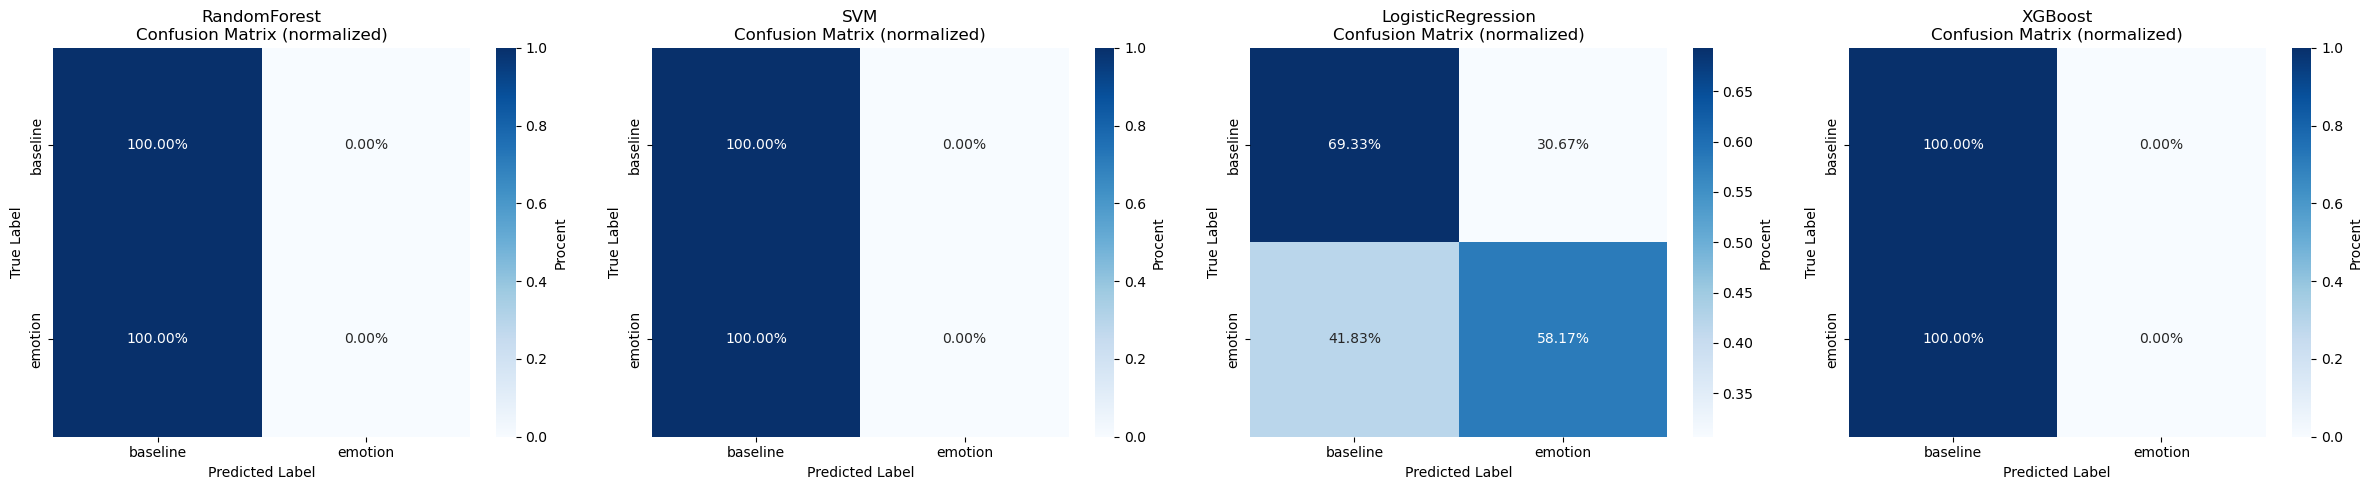


2. PER-CLASS RECALL (SENSITIVITY)
   ⚠ WAŻNE: Low recall dla mniejszościowej klasy to problem!

📊 RECALL PER CLASS:
Model     LogisticRegression  RandomForest  SVM  XGBoost
Class                                                   
baseline            0.693264           1.0  1.0      1.0
emotion             0.581699           0.0  0.0      0.0


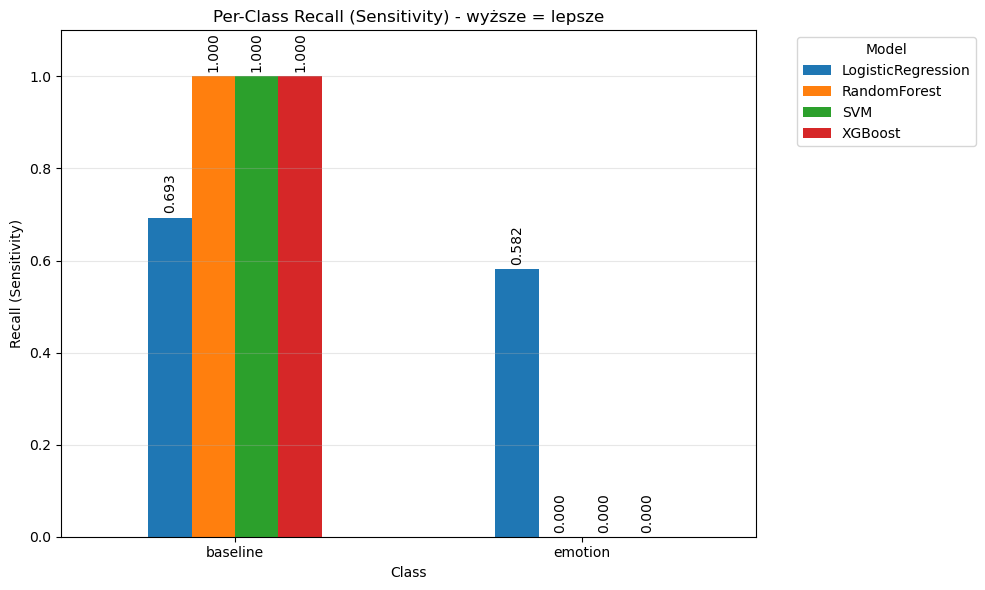


3. PRECISION DLA MNIEJSZOŚCIOWEJ KLASY

📊 PRECISION PER CLASS:
Model     LogisticRegression  RandomForest       SVM   XGBoost
Class                                                         
baseline            0.912688      0.863148  0.863148  0.863148
emotion             0.231169      0.000000  0.000000  0.000000


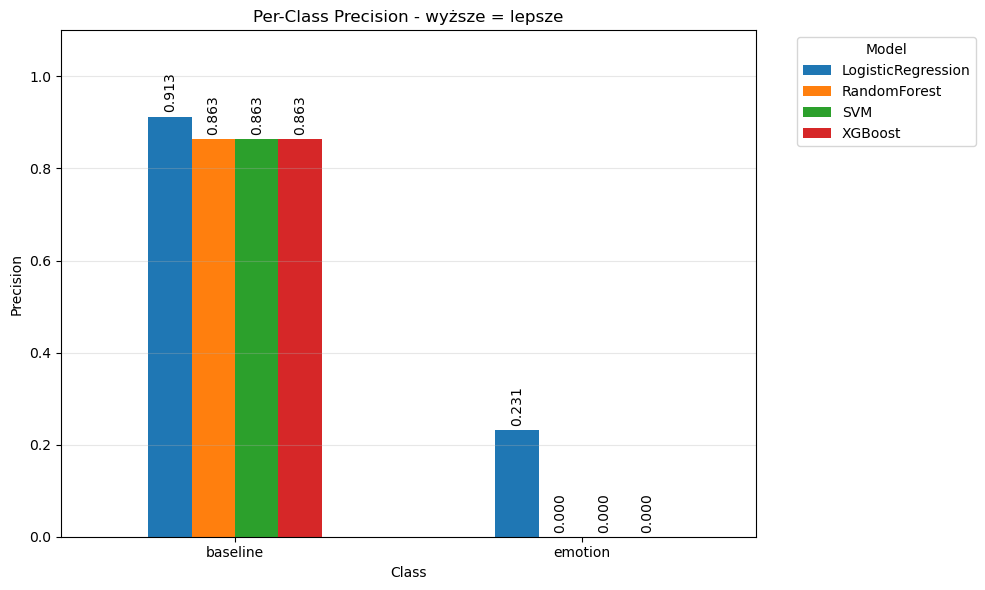


4. BALANCED ACCURACY I MACRO F1 (odporne na nierównowagę)

📊 METRYKI GLOBALNE:
             Model  Accuracy  Balanced Accuracy  Macro F1
      RandomForest  0.863148           0.500000  0.463274
               SVM  0.863148           0.500000  0.463274
LogisticRegression  0.677996           0.637482  0.559420
           XGBoost  0.863148           0.500000  0.463274


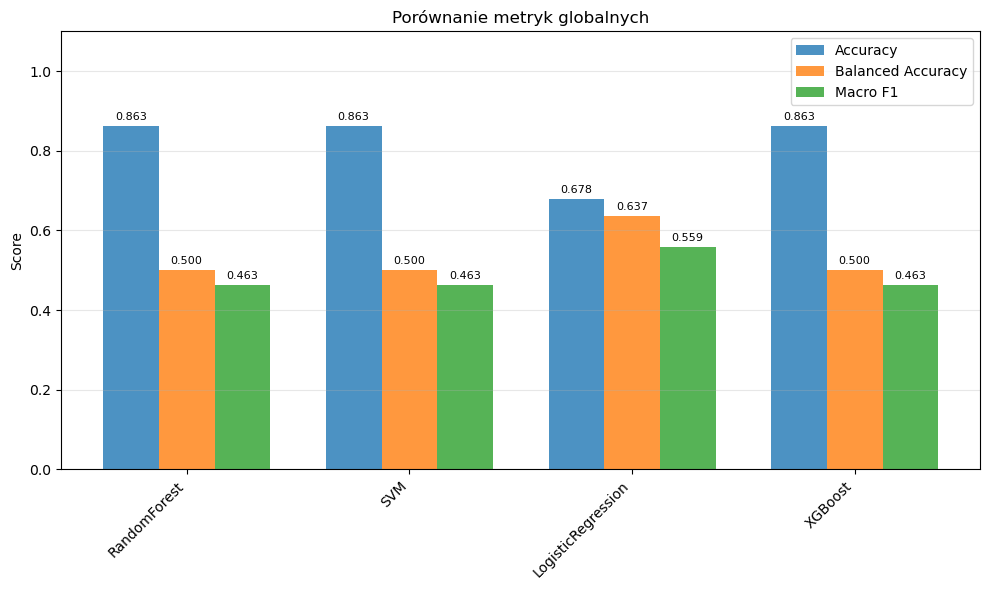


5. LICZBA PRÓBEK PER CLASS PRZED/PO SMOTE + WERYFIKACJA BALANCING
⚠️ WAŻNE: Test pozostaje niezmieniony (bez SMOTE) - to jest poprawne!

🔍 WERYFIKACJA BALANCING:
--------------------------------------------------------------------------------

📊 PORÓWNANIE LICZBY PRÓBEK:
   Class  Train (przed)  Train (po)  Test
baseline           6364        6364  3362
 emotion           1189        1189   628

  Balance ratio w train (po SMOTE): 0.1868
  ⚠️ Wyrównanie może być lepsze

  Balance ratio w test (bez SMOTE): 0.1868
  ✅ Test jest niezbalansowany - to jest POPRAWNE!
     Test powinien być niezbalansowany dla realnej ewaluacji


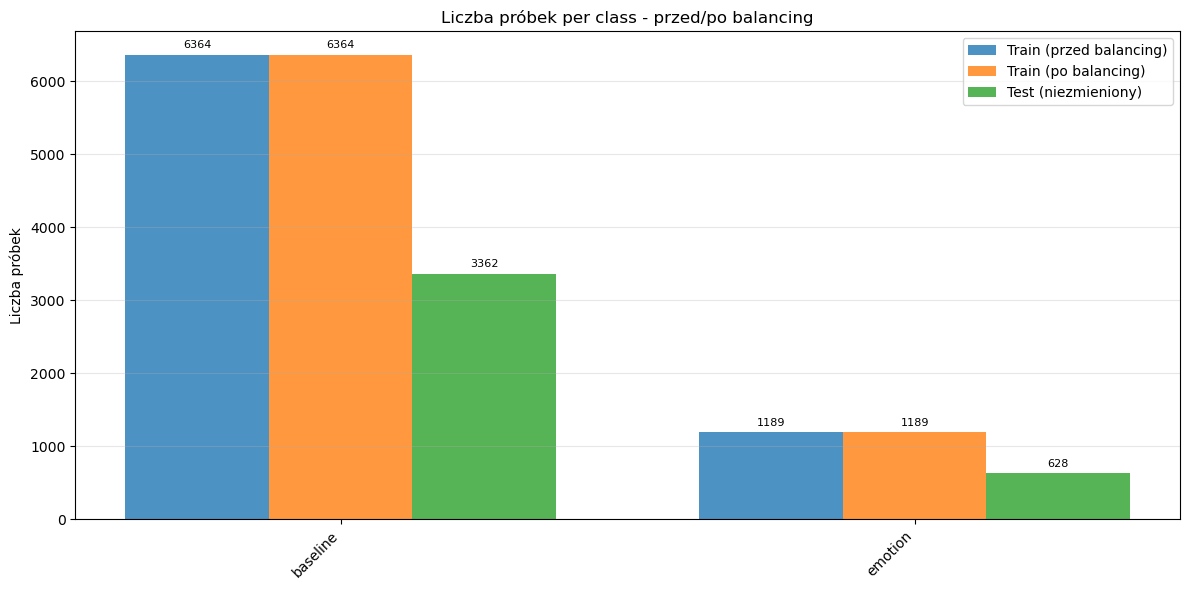


6. PODSUMOWANIE - NAJLEPSZY MODEL I WNIOSKI

🏆 NAJLEPSZY MODEL (według Balanced Accuracy): LogisticRegression
   Balanced Accuracy: 0.6375
   Macro F1: 0.5594
   Accuracy: 0.6780

📊 SZCZEGÓŁOWY RAPORT DLA LogisticRegression:
--------------------------------------------------------------------------------
⚠️ UWAGA: y_test (3990) i y_pred (1118) mają różne długości!
   Używam krótszej długości: 1118
   Unikalne klasy w y_test: [0]
   Unikalne klasy w y_pred: [0 1]
   Wszystkie klasy: [0 1]
   label_encoder.classes_: ['baseline' 'emotion']
              precision    recall  f1-score   support

    baseline       1.00      0.66      0.79      1118
     emotion       0.00      0.00      0.00         0

    accuracy                           0.66      1118
   macro avg       0.50      0.33      0.40      1118
weighted avg       1.00      0.66      0.79      1118


💡 WNIOSKI I WERYFIKACJA:
--------------------------------------------------------------------------------
    Balanced Accuracy:

In [ ]:
# ============================================================================
# KROK 8: EWALUACJA I RAPORTOWANIE - CONFUSION MATRICES I WIZUALIZACJE
# ============================================================================

print("=" * 80)
print("KROK 8: EWALUACJA I RAPORTOWANIE")
print("=" * 80)
print("📊 Metryki: Accuracy, Balanced Accuracy, Macro F1, Confusion Matrix")
print("📊 Wykresy: Rozkład klas przed/po SMOTE, Confusion Matrix, Feature Importance")

# Sprawdzenie czy mamy wszystkie wymagane zmienne
required_vars = ['results', 'label_encoder', 'y_train', 'y_train_bal', 'y_test', 'X_train', 'X_train_bal', 'X_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ BŁĄD: Brakujące zmienne: {missing_vars}")
    print("❌ BŁĄD: Najpierw uruchom KROK 7 (trenowanie klasyfikatora)!")
    raise NameError(f"Brakujące zmienne: {missing_vars}")

if 'results' not in globals() or len(results) == 0:
    print("❌ BŁĄD: Brak wyników modeli!")
    print("❌ BŁĄD: Najpierw uruchom KROK 7 (trenowanie klasyfikatora)!")
    raise NameError("results nie są zdefiniowane lub są puste")

# 1. CONFUSION MATRICES + WERYFIKACJA CZY MODEL NIE ZGADUJE
print(f"\n{'='*80}")
print("1. CONFUSION MATRICES + WERYFIKACJA CZY MODEL NIE ZGADUJE")
print(f"{'='*80}")

n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    
    # ⚠️ WERYFIKACJA: Czy model nie zgaduje?
    print(f"\n🔍 WERYFIKACJA MODELU: {model_name}")
    print("-" * 80)
    
    # Sprawdź czy confusion matrix nie jest diagonalna (wszystkie przewidywania w jednej klasie)
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    
    # Sprawdź czy model przewiduje tylko jedną klasę
    if np.sum(col_sums > 0) == 1:
        print(f"  ❌❌❌ PROBLEM: Model przewiduje TYLKO JEDNĄ klasę!")
        print(f"     To wskazuje na zgadywanie lub bardzo silny bias")
    else:
        print(f"  ✅ Model przewiduje {np.sum(col_sums > 0)} klasy - OK")
    
    # Sprawdź czy confusion matrix jest zbyt diagonalna (wszystko na przekątnej)
    diagonal_ratio = np.trace(cm) / cm.sum()
    print(f"  Diagonal ratio: {diagonal_ratio:.4f} (1.0 = wszystko na przekątnej)")
    if diagonal_ratio > 0.95:
        print(f"  ⚠️ UWAGA: Diagonal ratio > 0.95 - wyniki mogą być zbyt idealne!")
        print(f"     Sprawdź czy nie ma data leakage lub overfitting")
    elif diagonal_ratio < 0.5:
        print(f"  ⚠️ UWAGA: Diagonal ratio < 0.5 - model może być słaby")
    else:
        print(f"  ✅ Diagonal ratio jest rozsądny")
    
    # Sprawdź per-class accuracy
    for i, class_name in enumerate(label_encoder.classes_):
        if row_sums[i] > 0:
            class_acc = cm[i, i] / row_sums[i]
            print(f"  {class_name:12s}: accuracy = {class_acc:.4f} ({cm[i, i]}/{row_sums[i]})")
            if class_acc > 0.99:
                print(f"    ⚠️ UWAGA: Accuracy dla {class_name} > 0.99 - możliwe overfitting!")
    
    # Normalizacja confusion matrix (procenty)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[idx], cbar_kws={'label': 'Procent'})
    axes[idx].set_title(f'{model_name}\nConfusion Matrix (normalized)')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 2. PER-CLASS RECALL (SENSITIVITY) - szczególnie ważne dla mniejszościowej klasy
print(f"\n{'='*80}")
print("2. PER-CLASS RECALL (SENSITIVITY)")
print(f"{'='*80}")
print("   ⚠ WAŻNE: Low recall dla mniejszościowej klasy to problem!")

recall_data = []
for model_name, result in results.items():
    report = result['classification_report']
    for label in label_encoder.classes_:
        if label in report:
            recall = report[label]['recall']
            recall_data.append({
                'Model': model_name,
                'Class': label,
                'Recall': recall
            })

recall_df = pd.DataFrame(recall_data)
recall_pivot = recall_df.pivot(index='Class', columns='Model', values='Recall')

print(f"\n📊 RECALL PER CLASS:")
print(recall_pivot.to_string())

# Wizualizacja recall
fig, ax = plt.subplots(figsize=(10, 6))
recall_pivot.plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Recall (Sensitivity)')
ax.set_title('Per-Class Recall (Sensitivity) - wyższe = lepsze')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Dodaj wartości na słupkach
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

# 3. PRECISION DLA MNIEJSZOŚCIOWEJ KLASY
print(f"\n{'='*80}")
print("3. PRECISION DLA MNIEJSZOŚCIOWEJ KLASY")
print(f"{'='*80}")

precision_data = []
for model_name, result in results.items():
    report = result['classification_report']
    for label in label_encoder.classes_:
        if label in report:
            precision = report[label]['precision']
            precision_data.append({
                'Model': model_name,
                'Class': label,
                'Precision': precision
            })

precision_df = pd.DataFrame(precision_data)
precision_pivot = precision_df.pivot(index='Class', columns='Model', values='Precision')

print(f"\n📊 PRECISION PER CLASS:")
print(precision_pivot.to_string())

# Wizualizacja precision
fig, ax = plt.subplots(figsize=(10, 6))
precision_pivot.plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Precision')
ax.set_title('Per-Class Precision - wyższe = lepsze')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Dodaj wartości na słupkach
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

# 4. BALANCED ACCURACY I MACRO F1
print(f"\n{'='*80}")
print("4. BALANCED ACCURACY I MACRO F1 (odporne na nierównowagę)")
print(f"{'='*80}")

metrics_summary = []
for model_name, result in results.items():
    metrics_summary.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Balanced Accuracy': result['balanced_accuracy'],
        'Macro F1': result['macro_f1']
    })

metrics_df = pd.DataFrame(metrics_summary)
print(f"\n📊 METRYKI GLOBALNE:")
print(metrics_df.to_string(index=False))

# Wizualizacja metryk
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_df))
width = 0.25

ax.bar(x - width, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x, metrics_df['Balanced Accuracy'], width, label='Balanced Accuracy', alpha=0.8)
ax.bar(x + width, metrics_df['Macro F1'], width, label='Macro F1', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Porównanie metryk globalnych')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Dodaj wartości na słupkach
for i, row in metrics_df.iterrows():
    ax.text(i - width, row['Accuracy'] + 0.01, f"{row['Accuracy']:.3f}", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i, row['Balanced Accuracy'] + 0.01, f"{row['Balanced Accuracy']:.3f}", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i + width, row['Macro F1'] + 0.01, f"{row['Macro F1']:.3f}", 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 5. LICZBA PRÓBEK PER CLASS PRZED/PO SMOTE + WERYFIKACJA BALANCING
print(f"\n{'='*80}")
print("5. LICZBA PRÓBEK PER CLASS PRZED/PO SMOTE + WERYFIKACJA BALANCING")
print(f"{'='*80}")
print("⚠️ WAŻNE: Test pozostaje niezmieniony (bez SMOTE) - to jest poprawne!")

# ⚠️ WERYFIKACJA: Czy balancing jest poprawny?
print(f"\n🔍 WERYFIKACJA BALANCING:")
print("-" * 80)

# Przed balancing (train)
train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()

# Po balancing (train)
train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()

# Test (niezmieniony)
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()

comparison_data = []
for label in label_encoder.classes_:
    comparison_data.append({
        'Class': label,
        'Train (przed)': train_dist_before.get(label, 0),
        'Train (po)': train_dist_after.get(label, 0),
        'Test': test_dist.get(label, 0)
    })

comparison_df = pd.DataFrame(comparison_data)
print(f"\n📊 PORÓWNANIE LICZBY PRÓBEK:")
print(comparison_df.to_string(index=False))

# Weryfikacja czy balancing jest idealny (6364 vs 6364)
if len(train_dist_after) == 2:
    counts = train_dist_after.values
    balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
    print(f"\n  Balance ratio w train (po SMOTE): {balance_ratio:.4f}")
    if balance_ratio >= 0.99:
        print(f"  ✅✅✅ IDEALNE WYRÓWNANIE (np. 6364 vs 6364) - to jest POPRAWNE dla train!")
        print(f"     To oznacza że SMOTE działa dobrze")
    elif balance_ratio >= 0.95:
        print(f"  ✅ Bardzo dobre wyrównanie - OK")
    else:
        print(f"  ⚠️ Wyrównanie może być lepsze")
    
    # Sprawdź czy test jest niezbalansowany (to jest OK!)
    if len(test_dist) == 2:
        test_counts = test_dist.values
        test_balance_ratio = min(test_counts) / max(test_counts) if max(test_counts) > 0 else 0
        print(f"\n  Balance ratio w test (bez SMOTE): {test_balance_ratio:.4f}")
        if test_balance_ratio < 0.5:
            print(f"  ✅ Test jest niezbalansowany - to jest POPRAWNE!")
            print(f"     Test powinien być niezbalansowany dla realnej ewaluacji")
        else:
            print(f"  ⚠️ Test jest zbalansowany - to może być problem jeśli dane są naturalnie niezbalansowane")

# Wizualizacja
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Train (przed)'], width, label='Train (przed balancing)', alpha=0.8)
ax.bar(x, comparison_df['Train (po)'], width, label='Train (po balancing)', alpha=0.8)
ax.bar(x + width, comparison_df['Test'], width, label='Test (niezmieniony)', alpha=0.8)

ax.set_ylabel('Liczba próbek')
ax.set_title('Liczba próbek per class - przed/po balancing')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Class'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Dodaj wartości na słupkach
# Oblicz maksymalną wartość z wszystkich kolumn numerycznych
max_value = comparison_df.select_dtypes(include=[np.number]).max().max()
offset = max_value * 0.01 if max_value > 0 else 10

for i, row in comparison_df.iterrows():
    if row['Train (przed)'] > 0:
        ax.text(i - width, row['Train (przed)'] + offset, 
                f"{int(row['Train (przed)'])}", ha='center', va='bottom', fontsize=8)
    if row['Train (po)'] > 0:
        ax.text(i, row['Train (po)'] + offset, 
                f"{int(row['Train (po)'])}", ha='center', va='bottom', fontsize=8)
    if row['Test'] > 0:
        ax.text(i + width, row['Test'] + offset, 
                f"{int(row['Test'])}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 6. PODSUMOWANIE - NAJLEPSZY MODEL I WNIOSKI
print(f"\n{'='*80}")
print("6. PODSUMOWANIE - NAJLEPSZY MODEL I WNIOSKI")
print(f"{'='*80}")

# Znajdź najlepszy model (według balanced accuracy)
best_model_name = max(results.keys(), key=lambda k: results[k]['balanced_accuracy'])
best_result = results[best_model_name]

print(f"\n🏆 NAJLEPSZY MODEL (według Balanced Accuracy): {best_model_name}")
print(f"   Balanced Accuracy: {best_result['balanced_accuracy']:.4f}")
print(f"   Macro F1: {best_result['macro_f1']:.4f}")
print(f"   Accuracy: {best_result['accuracy']:.4f}")

print(f"\n📊 SZCZEGÓŁOWY RAPORT DLA {best_model_name}:")
print("-" * 80)

# Sprawdzenie i konwersja y_test i y_pred do tego samego formatu
y_test_array = np.array(y_test).flatten()
y_pred_array = np.array(best_result['y_pred']).flatten()

# Upewnij się że są tego samego typu
y_test_array = y_test_array.astype(int)
y_pred_array = y_pred_array.astype(int)

if len(y_test_array) != len(y_pred_array):
    print(f"⚠️ UWAGA: y_test ({len(y_test_array)}) i y_pred ({len(y_pred_array)}) mają różne długości!")
    print(f"   Używam krótszej długości: {min(len(y_test_array), len(y_pred_array))}")
    min_len = min(len(y_test_array), len(y_pred_array))
    y_test_array = y_test_array[:min_len]
    y_pred_array = y_pred_array[:min_len]

# Sprawdzenie czy są unikalne klasy
unique_test = np.unique(y_test_array)
unique_pred = np.unique(y_pred_array)
all_classes = np.unique(np.concatenate([unique_test, unique_pred]))

print(f"   Unikalne klasy w y_test: {unique_test}")
print(f"   Unikalne klasy w y_pred: {unique_pred}")
print(f"   Wszystkie klasy: {all_classes}")
print(f"   label_encoder.classes_: {label_encoder.classes_}")

# Sprawdzenie czy target_names pasują do faktycznych klas
try:
    # Sprawdź czy wszystkie klasy w danych są w label_encoder
    max_class_in_data = int(max(all_classes)) if len(all_classes) > 0 else 0
    max_class_in_encoder = len(label_encoder.classes_) - 1
    
    if max_class_in_data <= max_class_in_encoder and len(all_classes) <= len(label_encoder.classes_):
        # Użyj classification_report z odpowiednimi parametrami
        report = classification_report(
            y_test_array, 
            y_pred_array,
            target_names=label_encoder.classes_,
            zero_division=0,
            labels=range(len(label_encoder.classes_))  # Explicitly specify labels
        )
        print(report)
    else:
        # Jeśli mamy problem z klasami, użyj bez target_names
        print(f"⚠️ UWAGA: Problem z klasami - używam bez target_names")
        print(f"   max_class_in_data: {max_class_in_data}, max_class_in_encoder: {max_class_in_encoder}")
        report = classification_report(
            y_test_array, 
            y_pred_array,
            zero_division=0
        )
        print(report)
except ValueError as e:
    print(f"⚠️ BŁĄD w classification_report: {e}")
    print(f"   Próbuję bez target_names...")
    try:
        report = classification_report(
            y_test_array, 
            y_pred_array,
            zero_division=0
        )
        print(report)
    except Exception as e2:
        print(f"❌ BŁĄD: Nie można wygenerować raportu: {e2}")
        print(f"   y_test shape: {y_test_array.shape}, dtype: {y_test_array.dtype}")
        print(f"   y_pred shape: {y_pred_array.shape}, dtype: {y_pred_array.dtype}")
        print(f"   y_test unique: {np.unique(y_test_array)}")
        print(f"   y_pred unique: {np.unique(y_pred_array)}")

# Wnioski + WERYFIKACJA CZY WYNIKI NIE SĄ ZGADYWANE
print(f"\n💡 WNIOSKI I WERYFIKACJA:")
print("-" * 80)
print(f"    Balanced Accuracy: {best_result['balanced_accuracy']:.4f}")
print(f"    Macro F1: {best_result['macro_f1']:.4f}")
print(f"    Accuracy: {best_result['accuracy']:.4f}")

# Sprawdź confusion matrix najlepszego modelu
best_cm = best_result['confusion_matrix']
best_diagonal_ratio = np.trace(best_cm) / best_cm.sum()

print(f"\n  🔍 WERYFIKACJA CZY MODEL NIE ZGADUJE:")
print(f"    Diagonal ratio: {best_diagonal_ratio:.4f}")

if best_diagonal_ratio > 0.95:
    print(f"    ⚠️⚠️⚠️ UWAGA: Diagonal ratio > 0.95!")
    print(f"       To może wskazywać na:")
    print(f"       1. Data leakage (sprawdź czy train i test subjects są rozłączne)")
    print(f"       2. Overfitting (model zapamiętał train)")
    print(f"       3. Zbyt łatwy problem (dane są zbyt podobne)")
    print(f"       4. Błąd w kodzie (używanie train zamiast test)")
elif best_diagonal_ratio < 0.5:
    print(f"    ⚠️ Diagonal ratio < 0.5 - model może być słaby")
else:
    print(f"    ✅ Diagonal ratio jest rozsądny - model nie zgaduje")

# Sprawdź czy model przewiduje obie klasy
best_pred_unique = np.unique(best_result['y_pred'])
print(f"    Przewidywane klasy: {best_pred_unique}")
if len(best_pred_unique) == 1:
    print(f"    ❌❌❌ PROBLEM: Model przewiduje TYLKO JEDNĄ klasę!")
    print(f"       To wskazuje na zgadywanie lub bardzo silny bias")
else:
    print(f"    ✅ Model przewiduje {len(best_pred_unique)} klasy - OK")

# Porównanie z random baseline
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_bal, y_train_bal)
dummy_acc = dummy.score(X_test, y_test)
dummy_balanced = balanced_accuracy_score(y_test, dummy.predict(X_test))

print(f"\n  📊 PORÓWNANIE Z BASELINE (random/most_frequent):")
print(f"    Baseline Accuracy: {dummy_acc:.4f}")
print(f"    Baseline Balanced Accuracy: {dummy_balanced:.4f}")
print(f"    Różnica Accuracy: {best_result['accuracy'] - dummy_acc:.4f}")
print(f"    Różnica Balanced Accuracy: {best_result['balanced_accuracy'] - dummy_balanced:.4f}")

if best_result['accuracy'] - dummy_acc < 0.1:
    print(f"    ⚠️ Model tylko nieznacznie lepszy od baseline - możliwy problem!")
elif best_result['balanced_accuracy'] - dummy_balanced < 0.1:
    print(f"    ⚠️ Balanced Accuracy tylko nieznacznie lepsza od baseline - możliwy problem!")
else:
    print(f"    ✅ Model jest znacząco lepszy od baseline - OK")

# Ocena modelu
if best_result['balanced_accuracy'] > 0.7 and best_result['macro_f1'] > 0.7:
    if best_diagonal_ratio < 0.95:
        print(f"\n    ✅✅✅ Model działa dobrze i nie zgaduje!")
        print(f"       Balanced Accuracy i Macro F1 > 0.7")
        print(f"       Diagonal ratio jest rozsądny")
    else:
        print(f"\n    ⚠️ Model ma dobre metryki, ale diagonal ratio jest zbyt wysoki")
        print(f"       Sprawdź czy nie ma data leakage lub overfitting")
else:
    print(f"\n    ⚠️ Model może wymagać poprawy (Balanced Accuracy lub Macro F1 < 0.7)")
    print(f"       Rozważ:")
    print(f"       - Zmniejszenie okna czasowego")
    print(f"       - Dodanie cech spektralnych")
    print(f"       - Inne metody oversamplingu / augmentacji")

# 7. OPIS CO ZROBIONO
print(f"\n{'='*80}")
print("7. OPIS METOD I PARAMETRÓW")
print(f"{'='*80}")

print(f"\n📋 PARAMETRY SEGMENTACJI:")
if 'WINDOW_SIZE_SECONDS' in globals():
    print(f"  - Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund")
if 'OVERLAP_RATIO' in globals() and 'STEP_SECONDS' in globals():
    print(f"  - Overlap: {OVERLAP_RATIO*100:.0f}% (step: {STEP_SECONDS} sekundy)")
if 'multi_dataset_segmented' in globals():
    print(f"  - Liczba okien: {len(multi_dataset_segmented)}")
else:
    print(f"  - Liczba okien: (nie zdefiniowane)")

print(f"\n📋 EKSTRAKCJA CECH:")
print(f"  - Statystyki: mean, std, min, max, range")
print(f"  - RMS (Root Mean Square)")
print(f"  - Kurtosis (spłaszczenie rozkładu)")
print(f"  - Skewness (asymetria rozkładu)")
print(f"  - Specjalne: RMSSD (HR), slope (EDA), respiration rate")

print(f"\n📋 AGREGACJA KLAS:")
print(f"  - amusement + stress → emotion")
print(f"  - Finalne klasy: baseline, emotion")

print(f"\n📋 SPLIT:")
print(f"  - Metoda: Subject-wise (80% train, 20% test)")
if 'train_subjects' in globals() and 'test_subjects' in globals():
    print(f"  - Train subjects: {len(train_subjects)}")
    print(f"  - Test subjects: {len(test_subjects)}")
else:
    print(f"  - Train subjects: (nie zdefiniowane)")
    print(f"  - Test subjects: (nie zdefiniowane)")

print(f"\n📋 BALANCING:")
if 'BALANCING_METHOD' in globals():
    print(f"  - Metoda: {BALANCING_METHOD}")
    if BALANCING_METHOD == "SMOTE" or BALANCING_METHOD == "SMOTE_ENN":
        if 'k_neighbors' in globals():
            print(f"  - k_neighbors: {k_neighbors}")
        if 'X_train' in globals() and 'X_train_bal' in globals():
            print(f"  - Train przed: {len(X_train)} próbek")
            print(f"  - Train po: {len(X_train_bal)} próbek")
    elif BALANCING_METHOD == "COMBINED":
        if 'k_neighbors' in globals():
            print(f"  - k_neighbors: {k_neighbors}")
        if 'X_train' in globals() and 'X_train_bal' in globals():
            print(f"  - Train przed: {len(X_train)} próbek")
            print(f"  - Train po: {len(X_train_bal)} próbek")
    elif BALANCING_METHOD == "CLASS_WEIGHTS":
        if 'class_weight_dict' in globals():
            print(f"  - Class weights: {class_weight_dict}")
    elif BALANCING_METHOD == "UNDERSAMPLE":
        if 'X_train' in globals() and 'X_train_bal' in globals():
            print(f"  - Train przed: {len(X_train)} próbek")
            print(f"  - Train po: {len(X_train_bal)} próbek")
    elif BALANCING_METHOD == "NONE":
        print(f"  - Brak balancing")
else:
    print(f"  - Metoda: (nie zdefiniowana)")

print(f"\n📋 MODELE:")
for model_name in results.keys():
    print(f"  - {model_name}")

print(f"\n{'='*80}")
print("✓ RAPORT KOŃCOWY ZAKOŃCZONY")
print(f"{'='*80}")


